Goal of this Project
The primary goal of this project is to develop a robust model for forecasting electric power consumption in Tetouan, Morocco. Leveraging historical data and weather-related features, our objective is to create an accurate prediction tool that can assist in optimizing energy management within the city. By achieving this goal, we aim to enhance energy reliability, support data-driven decision-making in energy policy, and promote sustainable energy practices in Tetouan. This predictive model will empower us to proactively address energy demand fluctuations, particularly during extreme weather conditions, and contribute to the efficient allocation of electrical resources.

Dataset
The data used in this notebook comes from the Kaggle's Electric Power Consumption dataset. This dataset is a CSV file with 3 columns of electric power consumption recorded at a frequency of 6 samples per hour (1 sample every 10 minutes). Each of these 3 columns represents a zone of the city of Tétouan, in Morocco.

Features:

Date Time: Time window of ten minutes.
Temperature: Weather Temperature.
Humidity: Weather Humidity.
Wind Speed: Wind Speed.
General Diffuse Flows: “Diffuse flow” is a catchall term to describe low-temperature (< 0.2° to ~ 100°C) fluids that slowly discharge through sulfide mounds, fractured lava flows, and assemblages of bacterial mats and macrofauna.
Diffuse Flows
Target:

Zone 1 Power Consumption
Zone 2 Power Consumption
Zone 3 Power Consumption

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from xgboost import XGBRegressor
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import r2_score,mean_absolute_error,mean_absolute_percentage_error

In [2]:
from google.colab import files
uploaded=files.upload()

Saving powerconsumption.csv to powerconsumption.csv


In [33]:
#IMPORTING OUR DATASET
df=pd.read_csv('powerconsumption.csv')

##Exploring the dataset.

In [4]:
df.head(10)

Datetime  Temperature  Humidity  WindSpeed  GeneralDiffuseFlows  \
0  1/1/2017 0:00        6.559      73.8      0.083                0.051   
1  1/1/2017 0:10        6.414      74.5      0.083                0.070   
2  1/1/2017 0:20        6.313      74.5      0.080                0.062   
3  1/1/2017 0:30        6.121      75.0      0.083                0.091   
4  1/1/2017 0:40        5.921      75.7      0.081                0.048   
5  1/1/2017 0:50        5.853      76.9      0.081                0.059   
6  1/1/2017 1:00        5.641      77.7      0.080                0.048   
7  1/1/2017 1:10        5.496      78.2      0.085                0.055   
8  1/1/2017 1:20        5.678      78.1      0.081                0.066   
9  1/1/2017 1:30        5.491      77.3      0.082                0.062   

   DiffuseFlows  PowerConsumption_Zone1  PowerConsumption_Zone2  \
0         0.119             34055.69620             16128.87538   
1         0.085             29814.68354             19375.07599   
2         0.100             29128.10127             19006.68693   
3         0.096             28228.86076             18361.09422   
4         0.085             27335.69620             17872.34043   
5         0.108             26624.81013             17416.41337   
6         0.096             25998.98734             16993.31307   
7         0.093             25446.07595             16661.39818   
8         0.141             24777.72152             16227.35562   
9         0.111             24279.49367             15939.20973   

   PowerConsumption_Zone3  
0             20240.96386  
1             20131.08434  
2             19668.43373  
3             18899.27711  
4             18442.40964  
5             18130.12048  
6             17945.06024  
7             17459.27711  
8             17025.54217  
9             16794.21687

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Datetime                52416 non-null  object 
 1   Temperature             52416 non-null  float64
 2   Humidity                52416 non-null  float64
 3   WindSpeed               52416 non-null  float64
 4   GeneralDiffuseFlows     52416 non-null  float64
 5   DiffuseFlows            52416 non-null  float64
 6   PowerConsumption_Zone1  52416 non-null  float64
 7   PowerConsumption_Zone2  52416 non-null  float64
 8   PowerConsumption_Zone3  52416 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


In [6]:
df.shape

(52416, 9)

In [7]:
df.isna().sum()

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64

In [8]:
df.duplicated().sum()

0

#Visualize the dataset

In [19]:
df.columns

Index(['Datetime', 'Temperature', 'Humidity', 'WindSpeed',
       'GeneralDiffuseFlows', 'DiffuseFlows', 'PowerConsumption_Zone1',
       'PowerConsumption_Zone2', 'PowerConsumption_Zone3'],
      dtype='object')

In [34]:
df.columns=df.columns.str.strip()#The code snippet you provided is used to remove leading and trailing whitespaces from the column names of a Pandas DataFrame.
                                 #This can be helpful when working with data loaded from external sources,
                                #as column names with extra spaces can lead to issues when accessing or manipulating the data.

In [12]:
sns.pairplot(df[['Temperature', 'Humidity', 'WindSpeed',
       'GeneralDiffuseFlows', 'DiffuseFlows', 'PowerConsumption_Zone1',
       'PowerConsumption_Zone2', 'PowerConsumption_Zone3']])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [35]:
df['Datetime']=pd.to_datetime(df['Datetime'])#general step in all time series problems

In [36]:
df.sort_values(by='Datetime',ascending=True,inplace=True)


#general step in all time series problems
#errors='coerce': This parameter determines how to handle parsing errors. Setting it to 'coerce' will replace any parsing errors with NaT (Not a Timestamp) values.
#This is useful when dealing with data where some entries might be in an incorrect format, and you want to handle them gracefully without raising exceptions.
#utc=True: This parameter specifies whether to interpret the input datetime strings as UTC (Coordinated Universal Time).
#Setting it to True ensures that the parsed datetime objects are treated as UTC. You can adjust this based on your data's timezone information.

In [29]:
df.head()

Datetime  Temperature  Humidity  WindSpeed  GeneralDiffuseFlows  \
0  1/1/2017 0:00        6.559      73.8      0.083                0.051   
1  1/1/2017 0:10        6.414      74.5      0.083                0.070   
2  1/1/2017 0:20        6.313      74.5      0.080                0.062   
3  1/1/2017 0:30        6.121      75.0      0.083                0.091   
4  1/1/2017 0:40        5.921      75.7      0.081                0.048   

   DiffuseFlows  PowerConsumption_Zone1  PowerConsumption_Zone2  \
0         0.119             34055.69620             16128.87538   
1         0.085             29814.68354             19375.07599   
2         0.100             29128.10127             19006.68693   
3         0.096             28228.86076             18361.09422   
4         0.085             27335.69620             17872.34043   

   PowerConsumption_Zone3  
0             20240.96386  
1             20131.08434  
2             19668.43373  
3             18899.27711  
4             18442.40964

Text(0.5, 1.0, 'Power consumption-Time graph')

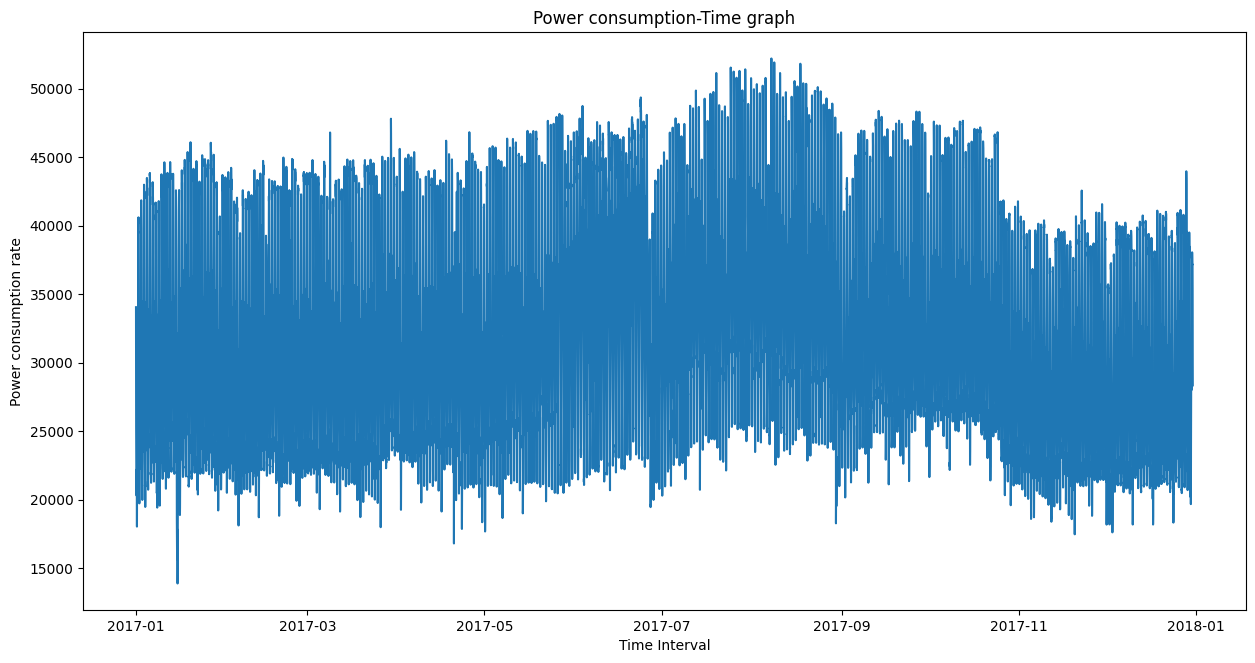

In [37]:
#Plotting graph for for power consuption zone 1
plt.figure(figsize=(15,7.5))
sns.lineplot(x='Datetime',y='PowerConsumption_Zone1',data=df)
plt.xlabel('Time Interval')
plt.ylabel('Power consumption rate')
plt.title('Power consumption-Time graph')


Text(0.5, 1.0, 'Power consumption-Time graph')

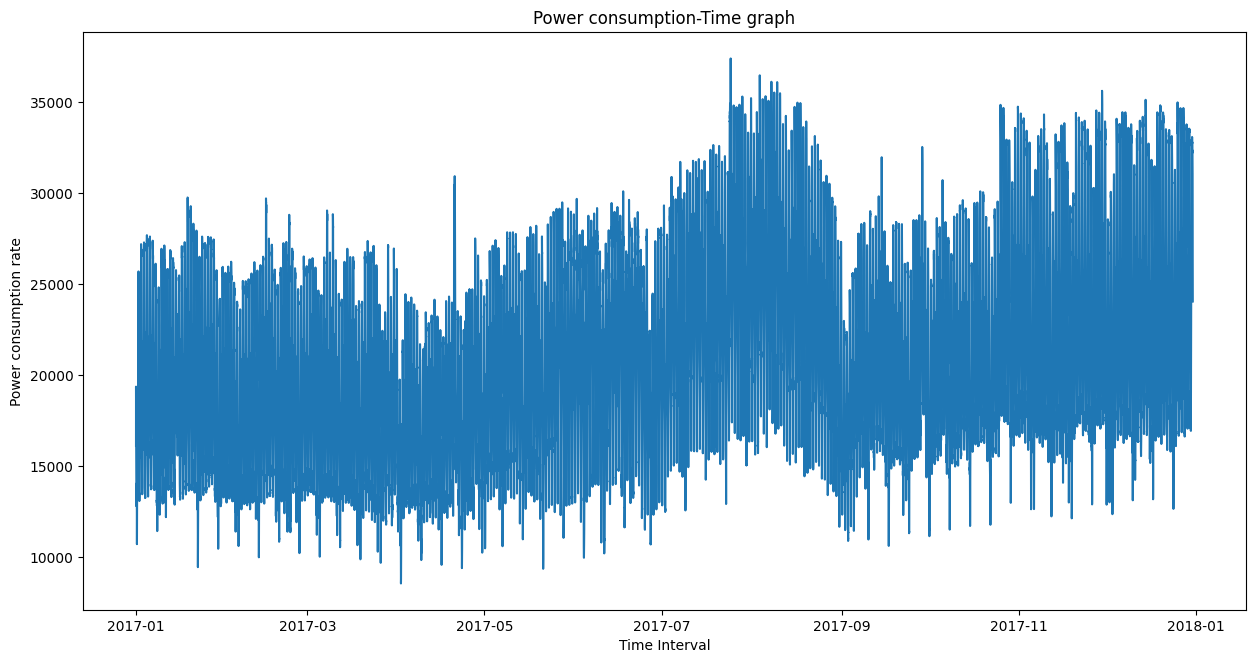

In [38]:
#Plotting graph for for power consuption zone 2
plt.figure(figsize=(15,7.5))
sns.lineplot(x='Datetime',y='PowerConsumption_Zone2',data=df)
plt.xlabel('Time Interval')
plt.ylabel('Power consumption rate')
plt.title('Power consumption-Time graph')

Text(0.5, 1.0, 'Power consumption-Time graph')

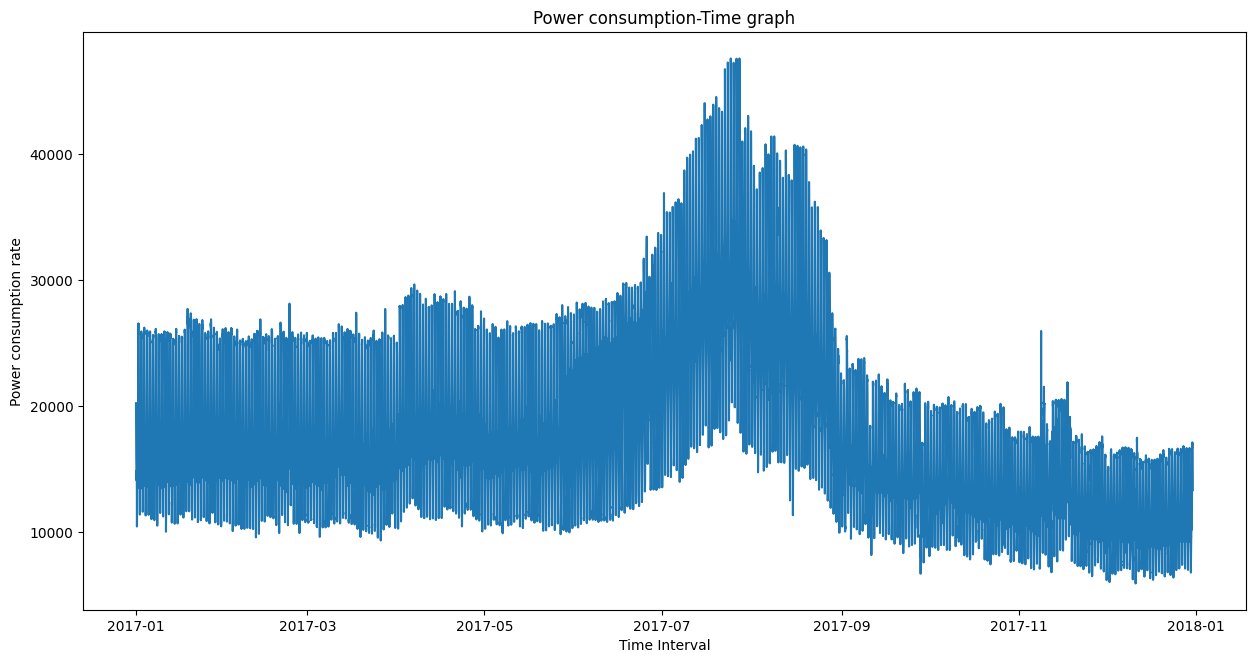

In [39]:
#Plotting graph for for power consuption zone 3
plt.figure(figsize=(15,7.5))
sns.lineplot(x='Datetime',y='PowerConsumption_Zone3',data=df)
plt.xlabel('Time Interval')
plt.ylabel('Power consumption rate')
plt.title('Power consumption-Time graph')

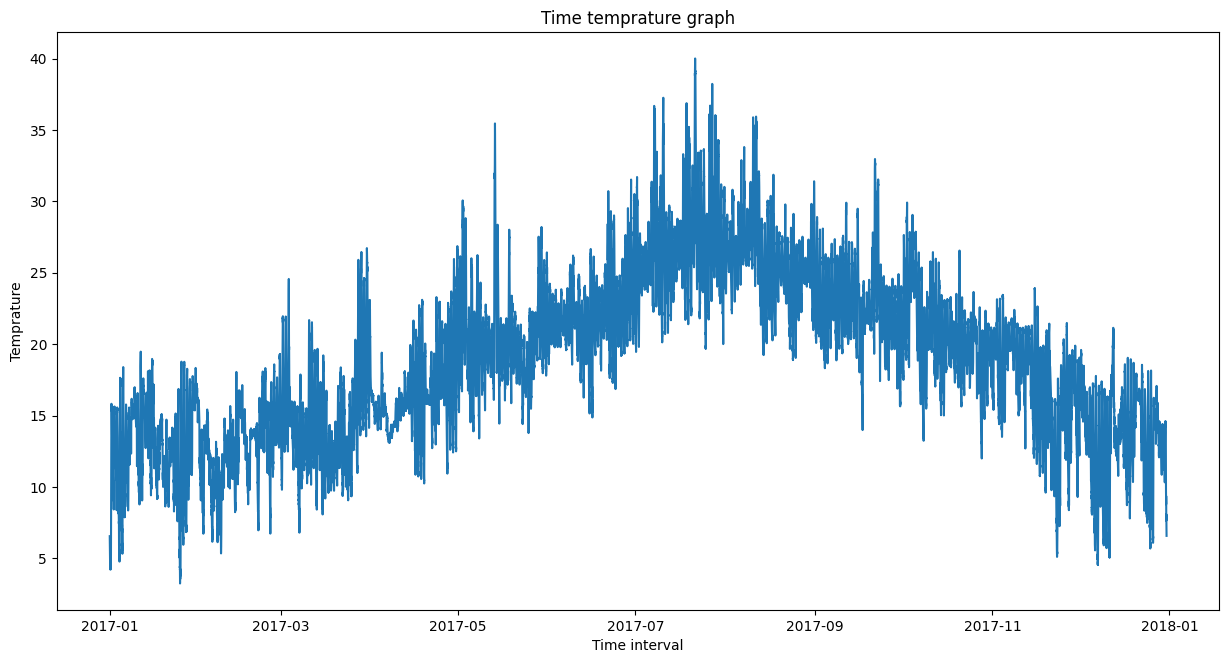

In [40]:
plt.figure(figsize=(15,7.5))
sns.lineplot(x='Datetime',y='Temperature',data=df)
plt.xlabel('Time interval')
plt.ylabel('Temprature')
plt.title('Time temprature graph')
plt.show()

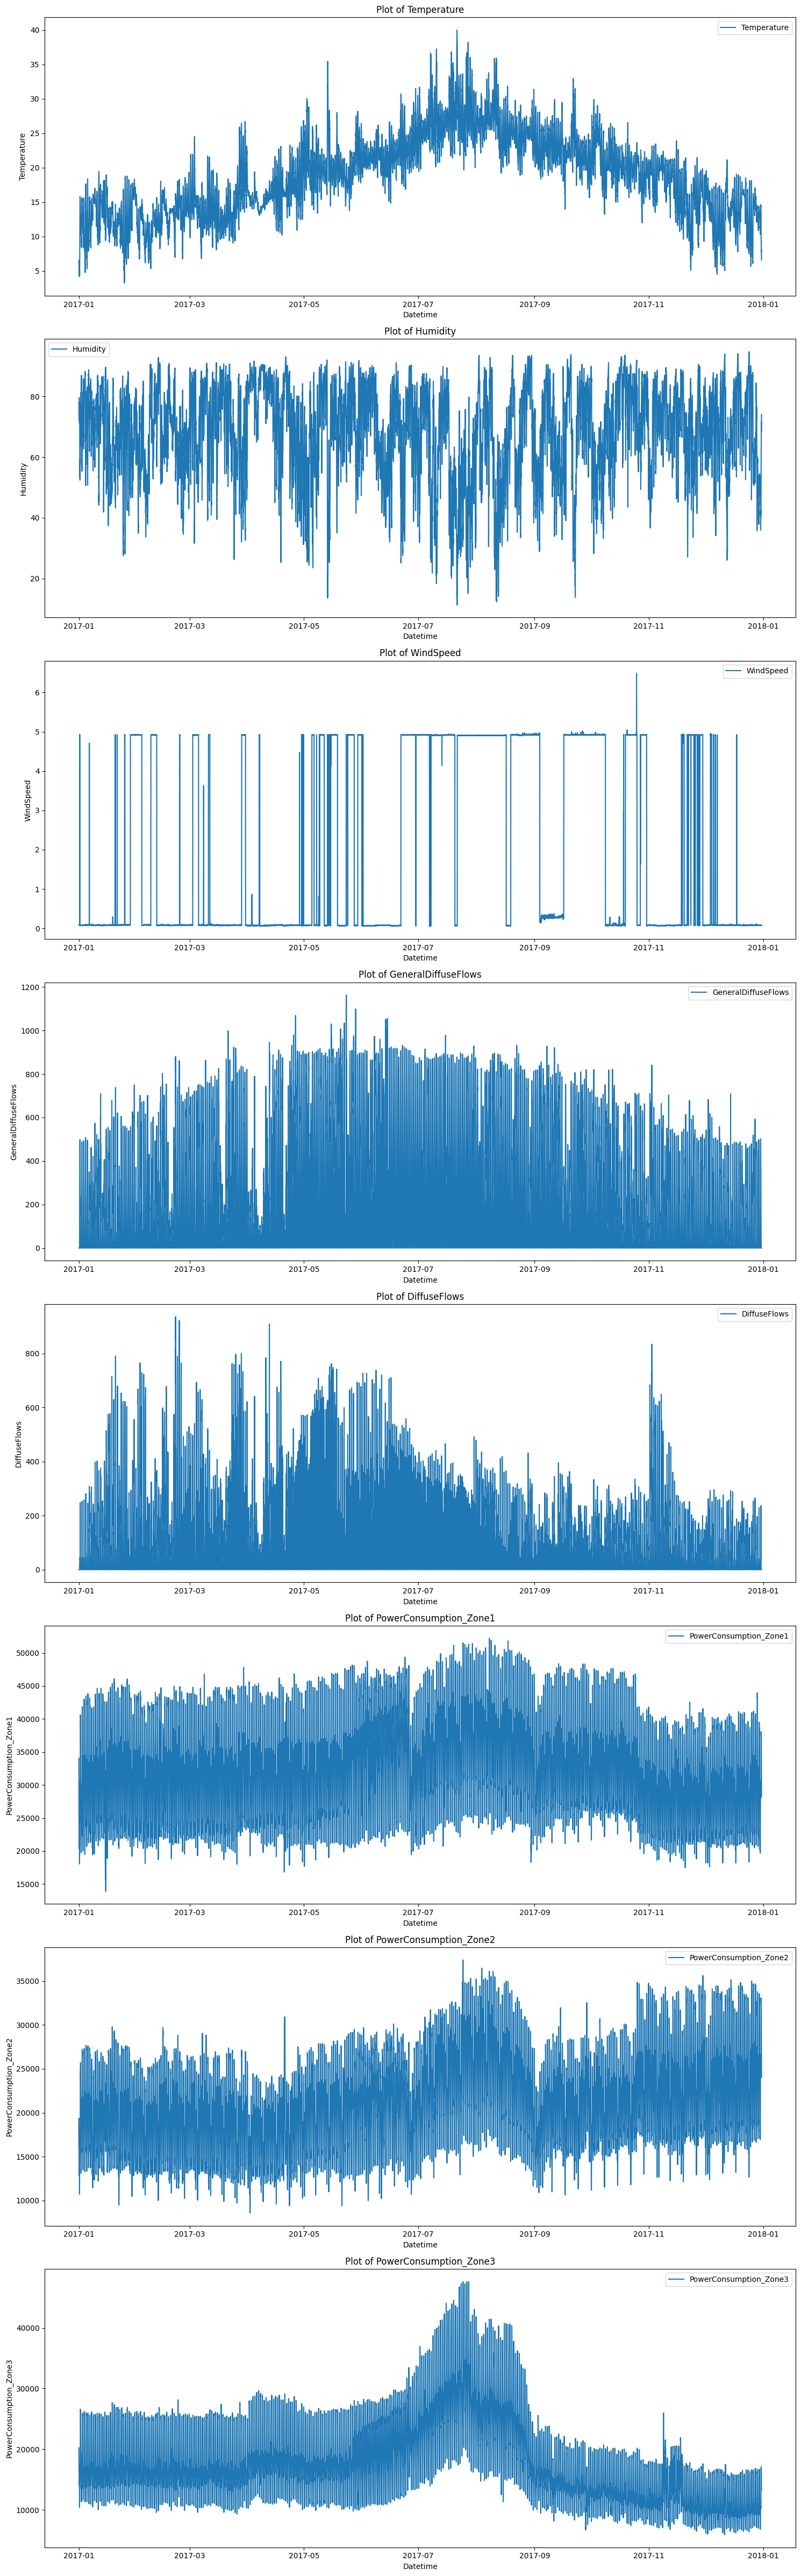

In [52]:
plot_col=df.columns.drop('Datetime')
no_of_figs=len(plot_col)
no_of_col=1
figures,axis=plt.subplots(no_of_figs,no_of_col,figsize=(15,no_of_figs*6))
for i,column in enumerate(plot_col):
  axis[i].plot(df['Datetime'], df[column], label=column)
  axis[i].set_xlabel('Datetime')
  axis[i].set_ylabel(column)
  axis[i].set_title(f'Plot of {column}')
  axis[i].legend()

# Adjust subplot spacing
plt.tight_layout()

# Show the plots
plt.show()


In [55]:
latest_date=df['Datetime'].max()

In [56]:
oldest_date=df['Datetime'].min()

In [57]:
print(latest_date-oldest_date)

363 days 23:50:00


#Checking for the choronological order of datetime series.
**Chronological order in time series data refers to the arrangement of data points or observations in a dataset based on their respective time or date stamps, with the earliest observations appearing first and the most recent ones appearing last. In other words, the data is organized in the order in which it was collected or recorded over a period of time.**

In [58]:
chrono=df['Datetime'].is_monotonic_increasing#Important step
chrono

True

In [60]:
time_diffs = df['Datetime'].diff()#.diff() is a Pandas function used to calculate the difference between each element in a Series
                                  #(in this case, the 'Datetime' column) and the previous element.
                                  #It computes the time difference between each timestamp and the one immediately preceding it.
time_diffs.nunique()

1

In [61]:
equidistant_timestamps = time_diffs.nunique() == 1
equidistant_timestamps

True

In [63]:
is_unique=df.Datetime.is_unique
is_unique
#is_unique: This function checks if all values in a Series or Index are unique.

True

#Feature Engineering

In [64]:
def create_features(df):
  df=df.copy()
  df['year']=df.index.year
  df['month']=df.index.month
  df['week']=df.index.week
  df['day']=df.index.day
  df['hour']=df.index.hour
  df['minute']=df.index.minute
  df['dayofweek'] = df.index.dayofweek
  df['quarter'] = df.index.quarter
  df['season'] = df['month'] % 12 // 3 + 1
  df['dayofyear'] = df.index.dayofyear
  df['dayofmonth'] = df.index.day
  df['weekofyear'] = df.index.isocalendar().week

  df['is_weekend']=df['dayofweek'].isin([5,6]).astype(int)
  df['is_month_start']=(df['dayofmonth']==1).astype(int)
  df['is_month_end']=(df['dayofmonth']==df.index.days_in_month).astype(int)
  df['is_quarter_start'] = (df['dayofmonth'] == 1) & (df['month'] % 3 == 1).astype(int)
  df['is_quarter_end'] = (df['dayofmonth'] == df.groupby(['year', 'quarter'])['dayofmonth'].transform('max'))
   # Additional features
  df['is_working_day'] = df['dayofweek'].isin([0, 1, 2, 3, 4]).astype(int)
  df['is_business_hours'] = df['hour'].between(9, 17).astype(int)
  df['is_peak_hour'] = df['hour'].isin([8, 12, 18]).astype(int)

    # Minute-level features
  df['minute_of_day'] = df['hour'] * 60 + df['minute']
  df['minute_of_week'] = (df['dayofweek'] * 24 * 60) + df['minute_of_day']

  return df.astype(float)


In [65]:
df=df.set_index('Datetime')

In [66]:
df=create_features(df)

<ipython-input-64-59547966a24b>:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week']=df.index.week


In [67]:
df.head()

Temperature  Humidity  WindSpeed  GeneralDiffuseFlows  \
Datetime                                                                     
2017-01-01 00:00:00        6.559      73.8      0.083                0.051   
2017-01-01 00:10:00        6.414      74.5      0.083                0.070   
2017-01-01 00:20:00        6.313      74.5      0.080                0.062   
2017-01-01 00:30:00        6.121      75.0      0.083                0.091   
2017-01-01 00:40:00        5.921      75.7      0.081                0.048   

                     DiffuseFlows  PowerConsumption_Zone1  \
Datetime                                                    
2017-01-01 00:00:00         0.119             34055.69620   
2017-01-01 00:10:00         0.085             29814.68354   
2017-01-01 00:20:00         0.100             29128.10127   
2017-01-01 00:30:00         0.096             28228.86076   
2017-01-01 00:40:00         0.085             27335.69620   

                     PowerConsumption_Zone2  PowerConsumption_Zone3    year  \
Datetime                                                                      
2017-01-01 00:00:00             16128.87538             20240.96386  2017.0   
2017-01-01 00:10:00             19375.07599             20131.08434  2017.0   
2017-01-01 00:20:00             19006.68693             19668.43373  2017.0   
2017-01-01 00:30:00             18361.09422             18899.27711  2017.0   
2017-01-01 00:40:00             17872.34043             18442.40964  2017.0   

                     month  ...  is_weekend  is_month_start  is_month_end  \
Datetime                    ...                                             
2017-01-01 00:00:00    1.0  ...         1.0             1.0           0.0   
2017-01-01 00:10:00    1.0  ...         1.0             1.0           0.0   
2017-01-01 00:20:00    1.0  ...         1.0             1.0           0.0   
2017-01-01 00:30:00    1.0  ...         1.0             1.0           0.0   
2017-01-01 00:40:00    1.0  ...         1.0             1.0           0.0   

                     is_quarter_start  is_quarter_end  is_working_day  \
Datetime                                                                
2017-01-01 00:00:00               1.0             0.0             0.0   
2017-01-01 00:10:00               1.0             0.0             0.0   
2017-01-01 00:20:00               1.0             0.0             0.0   
2017-01-01 00:30:00               1.0             0.0             0.0   
2017-01-01 00:40:00               1.0             0.0             0.0   

                     is_business_hours  is_peak_hour  minute_of_day  \
Datetime                                                              
2017-01-01 00:00:00                0.0           0.0            0.0   
2017-01-01 00:10:00                0.0           0.0           10.0   
2017-01-01 00:20:00                0.0           0.0           20.0   
2017-01-01 00:30:00                0.0           0.0           30.0   
2017-01-01 00:40:00                0.0           0.0           40.0   

                     minute_of_week  
Datetime                             
2017-01-01 00:00:00          8640.0  
2017-01-01 00:10:00          8650.0  
2017-01-01 00:20:00          8660.0  
2017-01-01 00:30:00          8670.0  
2017-01-01 00:40:00          8680.0  

[5 rows x 30 columns]

#EDA Part starts now
will extract some knowledge out of the data

In [68]:
correlation=df[['Temperature', 'Humidity', 'WindSpeed',
       'GeneralDiffuseFlows', 'DiffuseFlows', 'PowerConsumption_Zone1',
       'PowerConsumption_Zone2', 'PowerConsumption_Zone3']].corr()

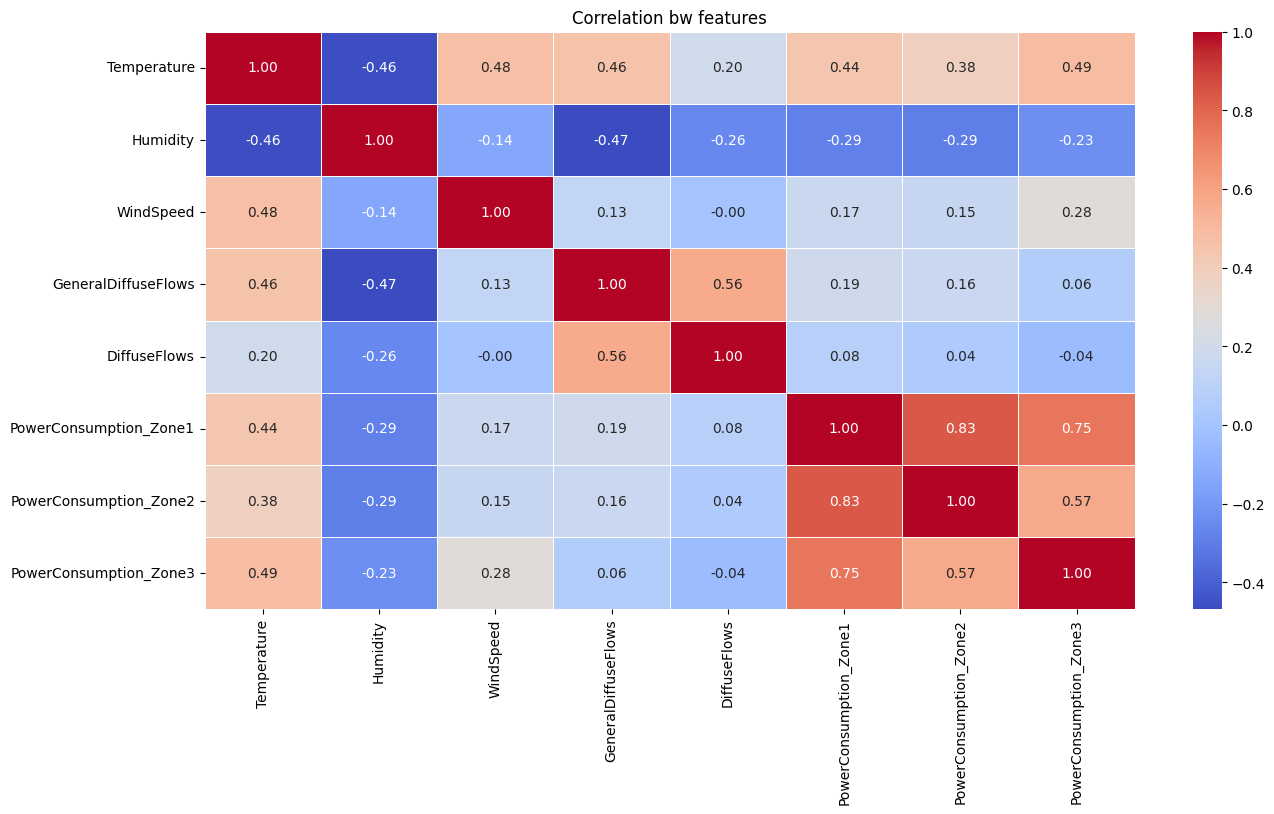

In [69]:
plt.figure(figsize=(15,7.5))
sns.heatmap(correlation,annot=True,cmap='coolwarm',fmt=".2f", linewidths=0.5)
plt.title('Correlation bw features')
plt.show()

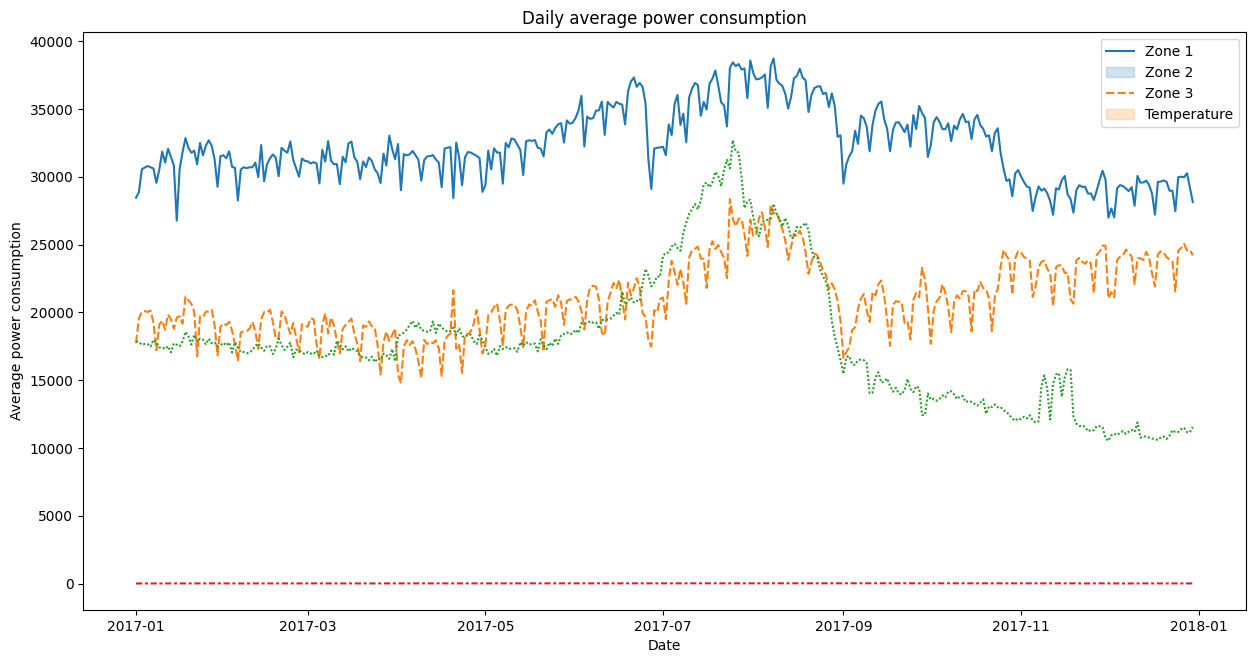

In [70]:
#Resampling the data on daily basis for more indepth knowledge
daily_resample=df.resample('D').mean()
plt.figure(figsize=(15,7.5))
sns.lineplot(data=daily_resample[['PowerConsumption_Zone1','PowerConsumption_Zone2','PowerConsumption_Zone3','Temperature']])
plt.title('Daily average power consumption')
plt.xlabel('Date')
plt.ylabel('Average power consumption')
plt.legend(['Zone 1','Zone 2','Zone 3','Temperature'])
plt.show()


In [72]:
daily_resample.columns

Index(['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
       'DiffuseFlows', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2',
       'PowerConsumption_Zone3', 'year', 'month', 'week', 'day', 'hour',
       'minute', 'dayofweek', 'quarter', 'season', 'dayofyear', 'dayofmonth',
       'weekofyear', 'is_weekend', 'is_month_start', 'is_month_end',
       'is_quarter_start', 'is_quarter_end', 'is_working_day',
       'is_business_hours', 'is_peak_hour', 'minute_of_day', 'minute_of_week'],
      dtype='object')

<Axes: xlabel='Datetime'>

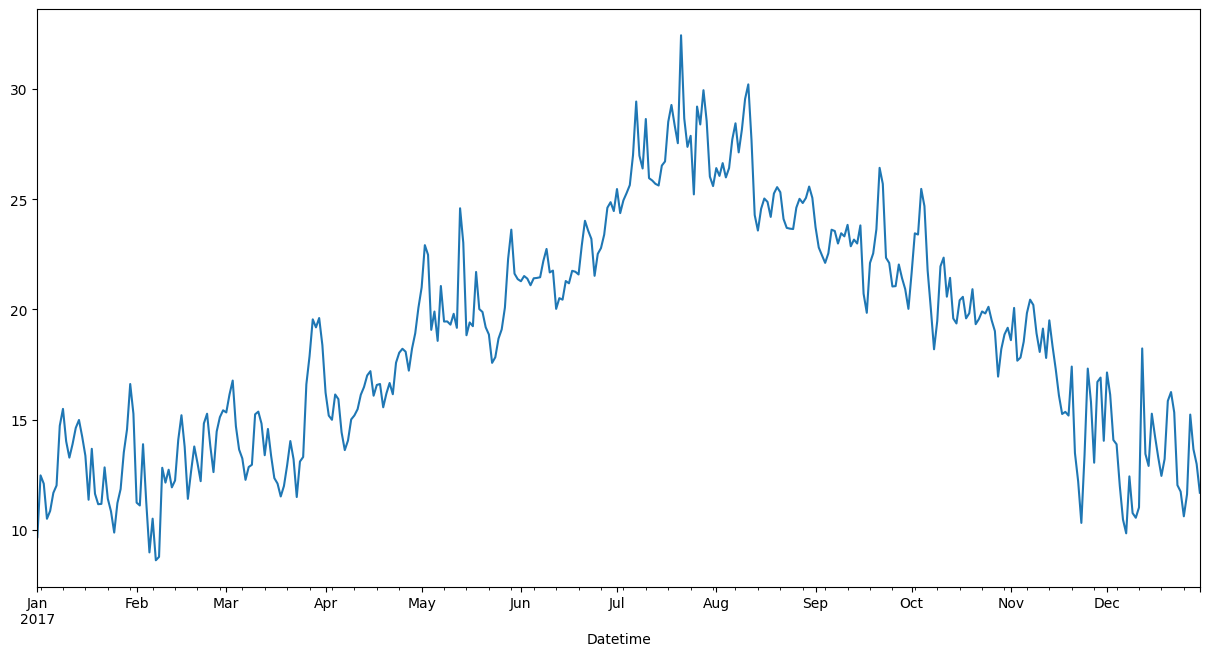

In [78]:
daily_resample['Temperature'].plot(figsize=(15,7.5))

<Axes: xlabel='Datetime'>

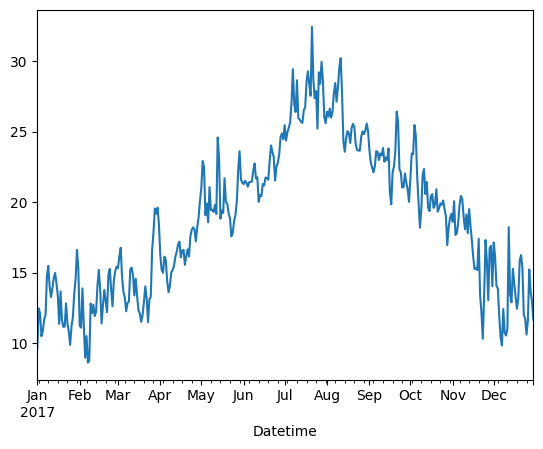

In [ ]:
daily_resample['Temperature'].plot()

Analyzing with moving averages

In [77]:
df.columns

Index(['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
       'DiffuseFlows', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2',
       'PowerConsumption_Zone3', 'year', 'month', 'week', 'day', 'hour',
       'minute', 'dayofweek', 'quarter', 'season', 'dayofyear', 'dayofmonth',
       'weekofyear', 'is_weekend', 'is_month_start', 'is_month_end',
       'is_quarter_start', 'is_quarter_end', 'is_working_day',
       'is_business_hours', 'is_peak_hour', 'minute_of_day', 'minute_of_week'],
      dtype='object')

In [79]:
target_cols=daily_resample[['PowerConsumption_Zone1', 'PowerConsumption_Zone2',
       'PowerConsumption_Zone3']]

In [80]:
features=daily_resample[['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
       'DiffuseFlows']]

In [81]:
corr_features=features.corr()

<Axes: >

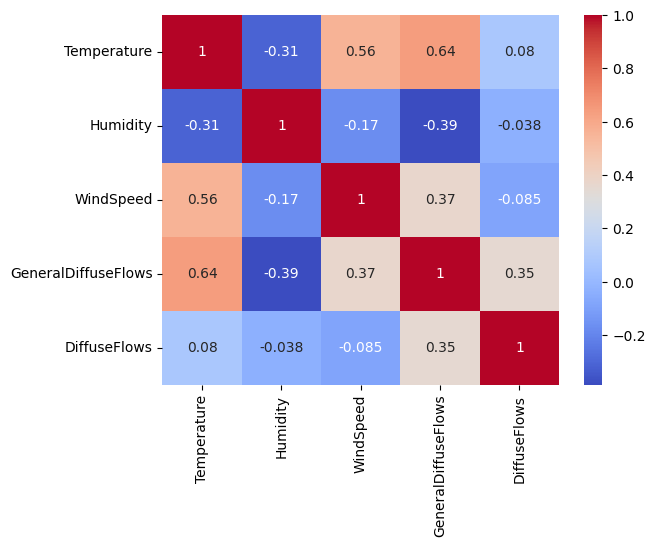

In [82]:
sns.heatmap(corr_features,cmap='coolwarm',annot=True)

In [83]:
features.drop(['DiffuseFlows'],inplace=True,axis=1)

<ipython-input-83-34ecc3d00091>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.drop(['DiffuseFlows'],inplace=True,axis=1)


In [84]:
features.corr().abs()

Temperature  Humidity  WindSpeed  GeneralDiffuseFlows
Temperature             1.000000  0.311480   0.561112             0.637711
Humidity                0.311480  1.000000   0.171981             0.385401
WindSpeed               0.561112  0.171981   1.000000             0.367730
GeneralDiffuseFlows     0.637711  0.385401   0.367730             1.000000

In [ ]:
features.head()

Temperature   Humidity  WindSpeed  GeneralDiffuseFlows
Datetime                                                          
2017-01-01     9.675299  68.519306   0.315146           121.390771
2017-01-02    12.476875  71.456319   0.076563           120.404486
2017-01-03    12.100000  74.981667   0.076715           120.686014
2017-01-04    10.509479  75.459792   0.082417           122.959319
2017-01-05    10.866444  71.040486   0.083896           118.749861

ConversionError: ignored

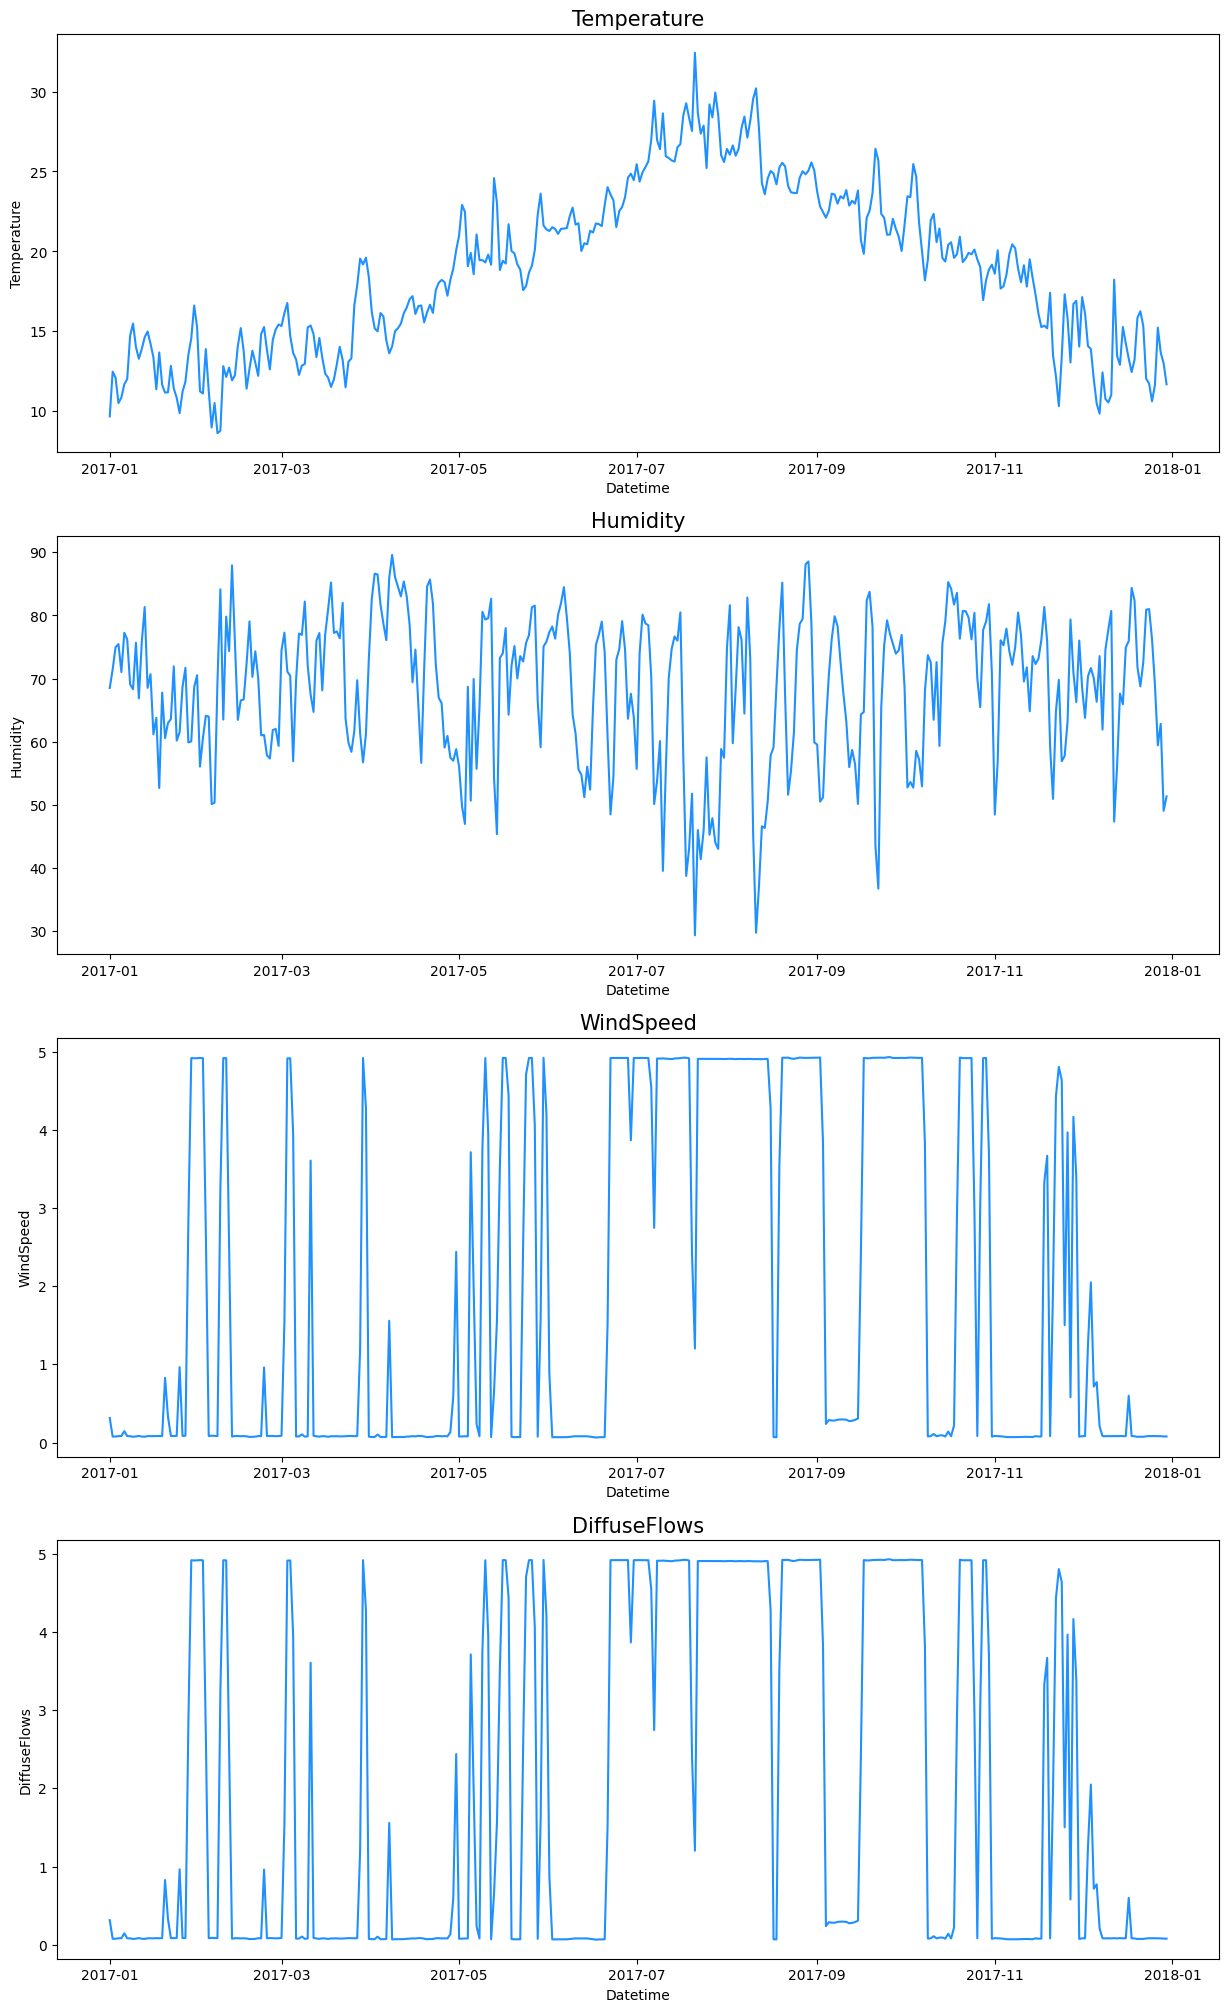

In [85]:
fig,axis=plt.subplots(nrows=4,ncols=1,figsize=(15,25))
sns.lineplot(x=daily_resample.index,y=daily_resample.Temperature,ax=axis[0],color='dodgerblue')
axis[0].set_title('Temperature',fontsize=15)
axis[0].set_ylabel('Temperature')

sns.lineplot(x=daily_resample.index,y=daily_resample.Humidity,ax=axis[1],color='dodgerblue')
axis[1].set_title('Humidity',fontsize=15)
axis[1].set_ylabel('Humidity')

sns.lineplot(x=daily_resample.index,y=daily_resample.WindSpeed,ax=axis[2],color='dodgerblue')
axis[2].set_title('WindSpeed',fontsize=15)
axis[2].set_ylabel('WindSpeed')

sns.lineplot(x=daily_resample.index,y=daily_resample.WindSpeed,ax=axis[3],color='dodgerblue')
axis[3].set_title('DiffuseFlows',fontsize=15)
axis[3].set_ylabel('DiffuseFlows')

for i in range(4):
    # Set the x-axis limits using set_xlim
    axis[i].set_xlim(['2017-01-01', '2017-12-31'])

plt.show()

In [86]:
daily_resample['WindSpeed'].eq(0).sum()

0

## Stationarity

Some time-series models, such as such as [ARIMA](#ARIMA), assume that the underlying data is stationary.
Stationarity describes that the time-series has
* constant mean and mean is not time-dependent
* constant variance and variance is not time-dependent
* constant covariance and covariance is not time-dependent

> If a time series has a specific (stationary) behavior over a given time interval, then it can be assumed that the time series will behave the same at a later time.

Time series **with trend and/or seasonality are not stationary**. Trend indicates that the mean is not constant over time and seasonality indicates that the variance is not constant over time.

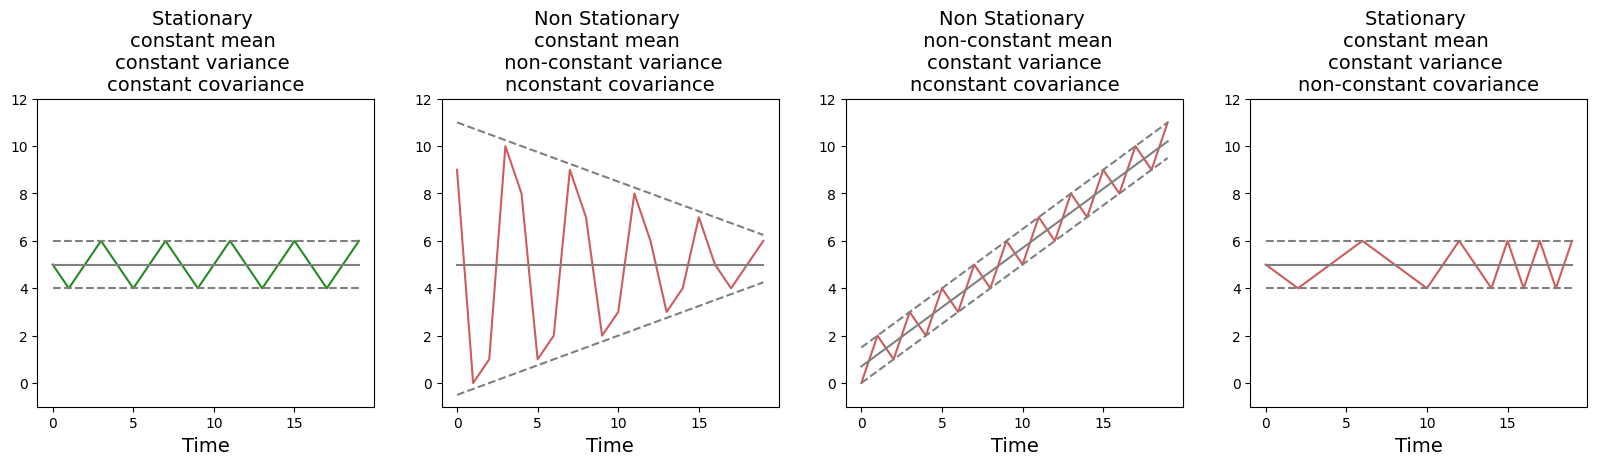

In [ ]:
t = np.linspace(0, 19, 20)

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20,4))
stationary = [5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6,]
sns.lineplot(x=t, y=stationary, ax=ax[0], color='forestgreen')
sns.lineplot(x=t, y=5, ax=ax[0], color='grey')
sns.lineplot(x=t, y=6, ax=ax[0], color='grey')
sns.lineplot(x=t, y=4, ax=ax[0], color='grey')
ax[0].lines[2].set_linestyle("--")
ax[0].lines[3].set_linestyle("--")
ax[0].set_title(f'Stationary \nconstant mean \nconstant variance \nconstant covariance', fontsize=14)

nonstationary1 = [ 9, 0, 1, 10, 8, 1, 2, 9, 7, 2, 3, 8, 6, 3, 4, 7, 5, 4, 5, 6]
sns.lineplot(x=t, y=nonstationary1, ax=ax[1], color='indianred' )
sns.lineplot(x=t, y=5, ax=ax[1], color='grey')
sns.lineplot(x=t, y=t*0.25-0.5, ax=ax[1], color='grey')
sns.lineplot(x=t, y=t*(-0.25)+11, ax=ax[1], color='grey')
ax[1].lines[2].set_linestyle("--")
ax[1].lines[3].set_linestyle("--")
ax[1].set_title(f'Non Stationary \nconstant mean \n non-constant variance\nnconstant covariance', fontsize=14)

nonstationary2 = [0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11,]
sns.lineplot(x=t, y=nonstationary2, ax=ax[2], color='indianred' )
sns.lineplot(x=t, y=t*0.5+0.7, ax=ax[2], color='grey')
sns.lineplot(x=t, y=t*0.5, ax=ax[2], color='grey')
sns.lineplot(x=t, y=t*0.5+1.5, ax=ax[2], color='grey')
ax[2].lines[2].set_linestyle("--")
ax[2].lines[3].set_linestyle("--")
ax[2].set_title(f'Non Stationary \n non-constant mean\nconstant variance\nnconstant covariance', fontsize=14)

nonstationary3 = [5, 4.5, 4, 4.5, 5, 5.5, 6, 5.5, 5, 4.5, 4, 5, 6, 5, 4, 6, 4, 6, 4, 6,]
sns.lineplot(x=t, y=nonstationary3, ax=ax[3], color='indianred')
sns.lineplot(x=t, y=5, ax=ax[3], color='grey')
sns.lineplot(x=t, y=6, ax=ax[3], color='grey')
sns.lineplot(x=t, y=4, ax=ax[3], color='grey')
ax[3].lines[2].set_linestyle("--")
ax[3].lines[3].set_linestyle("--")
ax[3].set_title(f'Stationary \nconstant mean \nconstant variance \nnon-constant covariance', fontsize=14)

for i in range(4):
    ax[i].set_ylim([-1, 12])
    ax[i].set_xlabel('Time', fontsize=14)

The check for stationarity can be done via three different approaches:
1. **visually**: plot time series and check for trends or seasonality
2. **basic statistics**: split time series and compare the mean and variance of each partition
3. **statistical test**: Augmented Dickey Fuller test

Let's do the **visual check** first. We can see that all features except `Temperature` have non-constant mean and non-constant variance. Therefore, **none of these seem to be stationary**. However, `Temperature` shows strong seasonality (hot in summer, cold in winter) and therefore it is not stationary either.

In [93]:
#Comparing the consuption of power of all the zones with simple moving average.
daily_resample['Zone-1 rolling 5 days']=daily_resample['PowerConsumption_Zone1'].rolling(window=5).mean()
daily_resample['Zone-2 rolling 5 days']=daily_resample['PowerConsumption_Zone2'].rolling(window=5).mean()
daily_resample['Zone-3 rolling 5 days']=daily_resample['PowerConsumption_Zone3'].rolling(window=5).mean()

##checking stationarity for both dependent and independent variables is essential in a time series problem because it ensures that your modeling assumptions are met,
##your models are reliable, and your predictions are accurate.
##If any of your variables are non-stationary,
##you may need to apply appropriate transformations or differencing to make them stationary before building your time series model.

<Axes: xlabel='Datetime'>

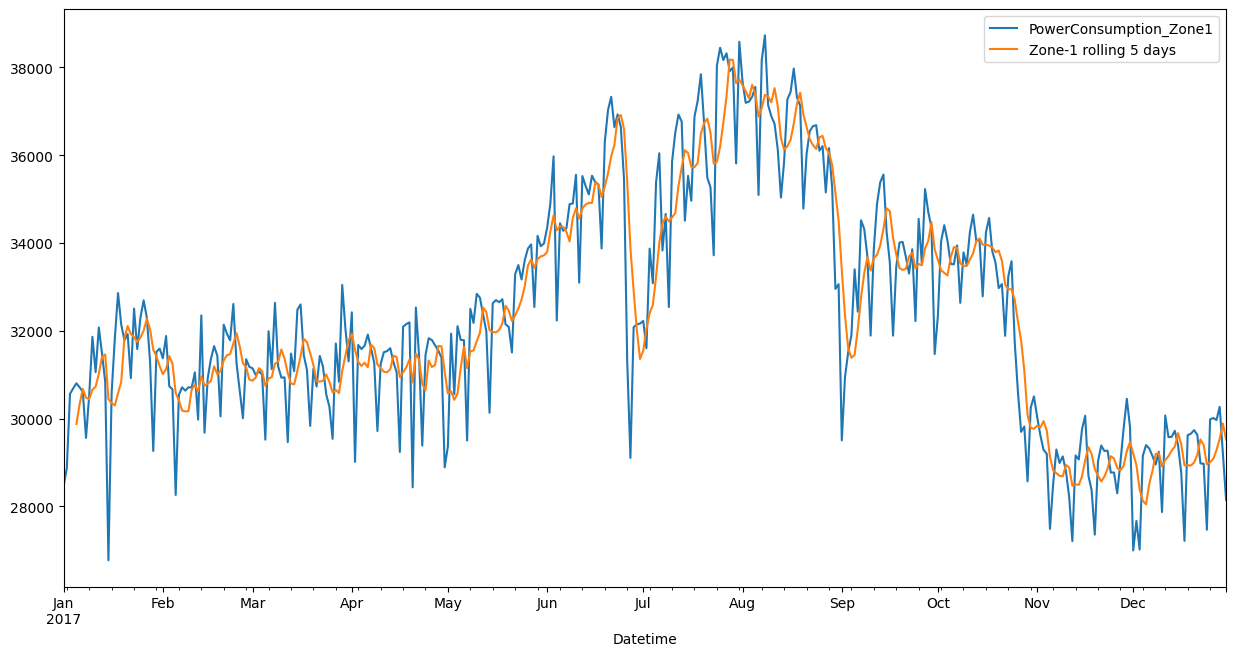

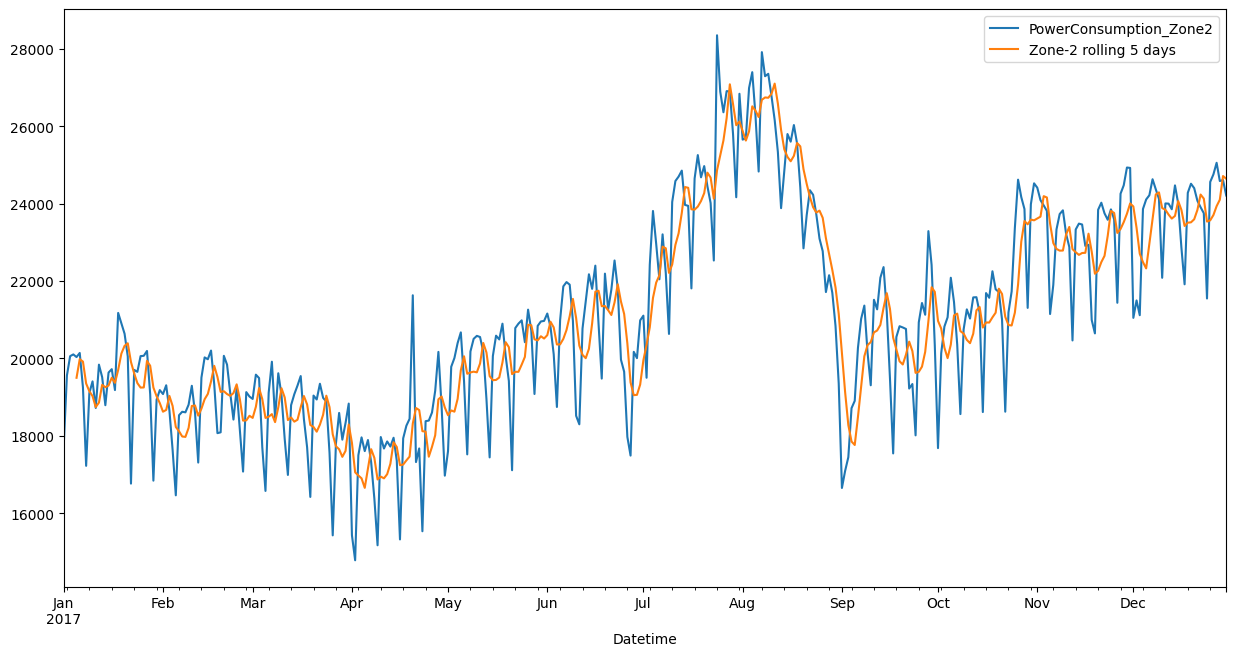

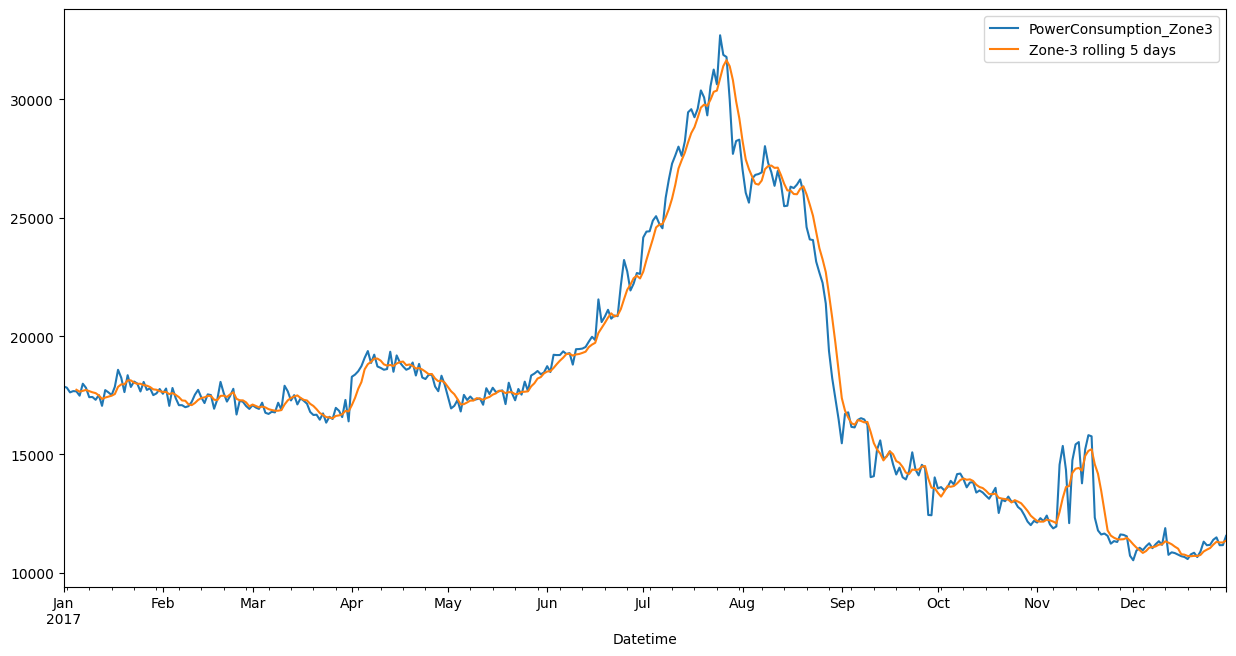

In [94]:
daily_resample[['PowerConsumption_Zone1','Zone-1 rolling 5 days']].plot(figsize=(15,7.5))
daily_resample[['PowerConsumption_Zone2','Zone-2 rolling 5 days']].plot(figsize=(15,7.5))
daily_resample[['PowerConsumption_Zone3','Zone-3 rolling 5 days']].plot(figsize=(15,7.5))

In [89]:
#Comparing the consuption of power of all the zones with cumulative moving average moving average.
daily_resample['Zone-1 cma']=daily_resample['PowerConsumption_Zone1'].expanding().mean()
daily_resample['Zone-2 cma']=daily_resample['PowerConsumption_Zone2'].expanding().mean()
daily_resample['Zone-3 cma']=daily_resample['PowerConsumption_Zone3'].expanding().mean()

<Axes: xlabel='Datetime'>

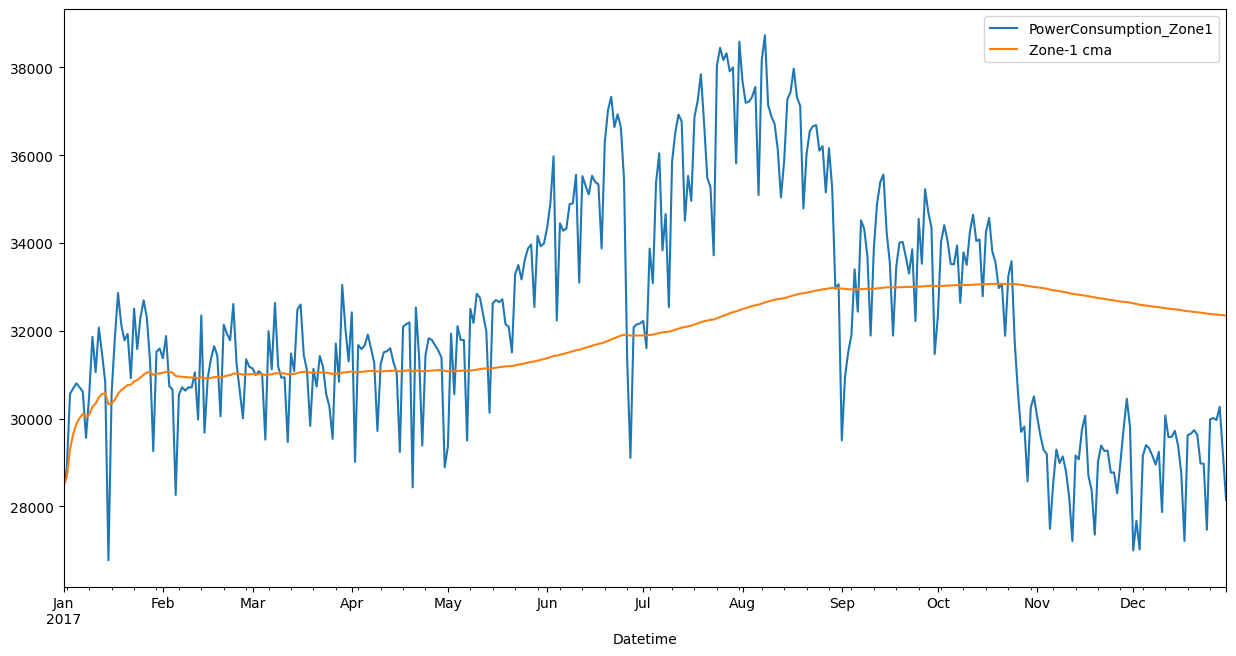

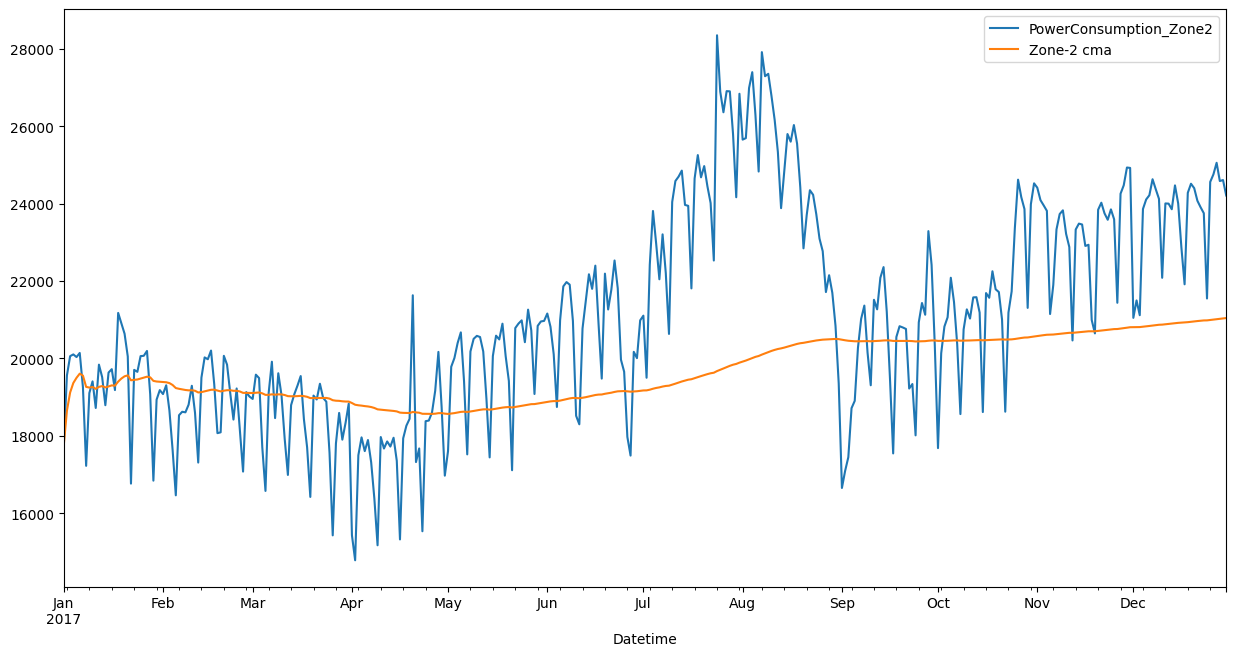

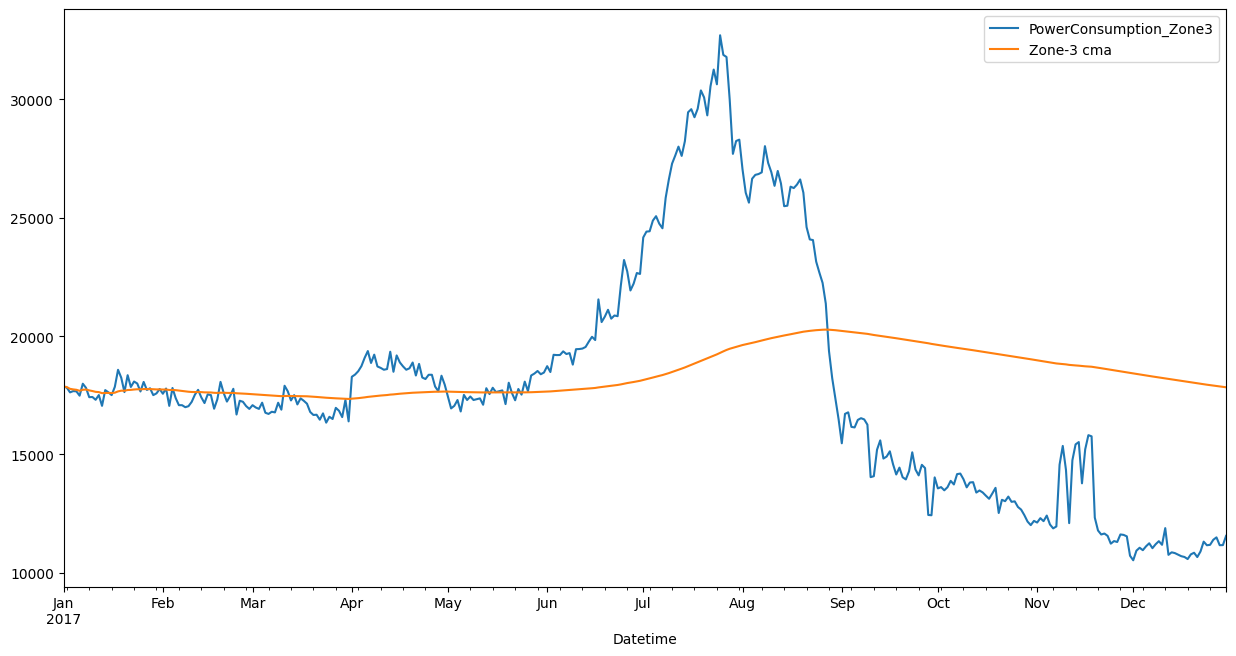

In [88]:
daily_resample[['PowerConsumption_Zone1','Zone-1 cma']].plot(figsize=(15,7.5))
daily_resample[['PowerConsumption_Zone2','Zone-2 cma']].plot(figsize=(15,7.5))
daily_resample[['PowerConsumption_Zone3','Zone-3 cma']].plot(figsize=(15,7.5))

In [90]:
daily_resample['Zone-1 ewma']=daily_resample['PowerConsumption_Zone1'].ewm(span=5).mean()
daily_resample['Zone-2 ewma']=daily_resample['PowerConsumption_Zone2'].ewm(span=5).mean()
daily_resample['Zone-3 ewma']=daily_resample['PowerConsumption_Zone3'].ewm(span=5).mean()

<Axes: xlabel='Datetime'>

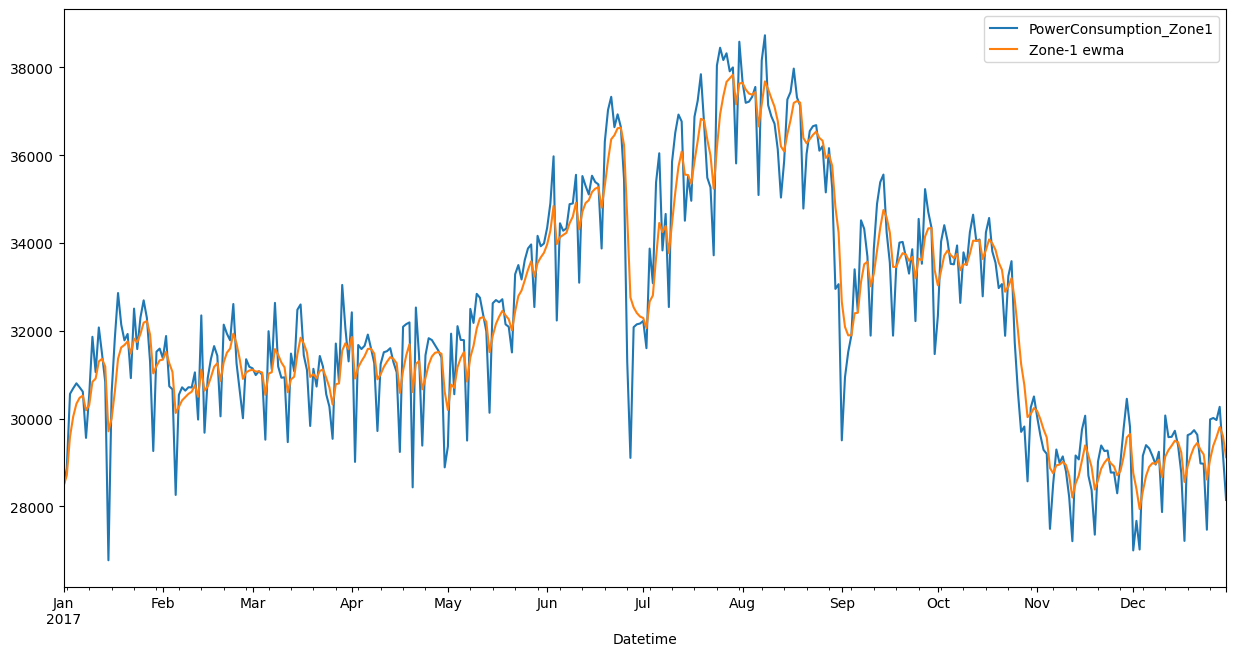

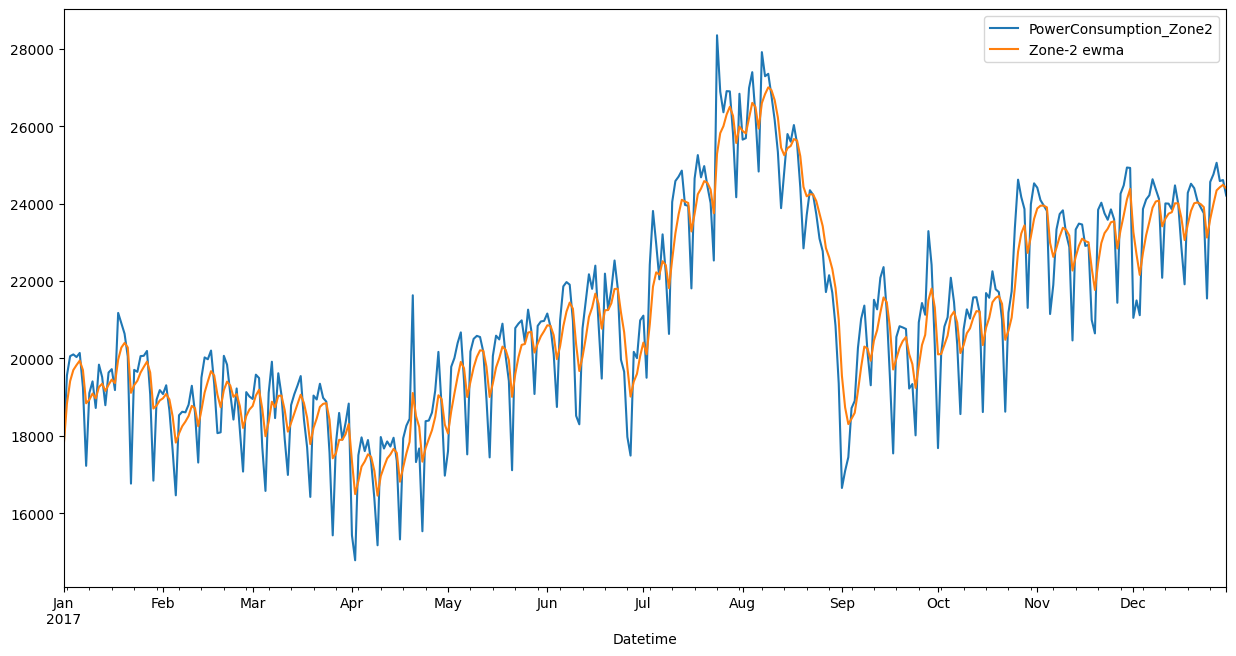

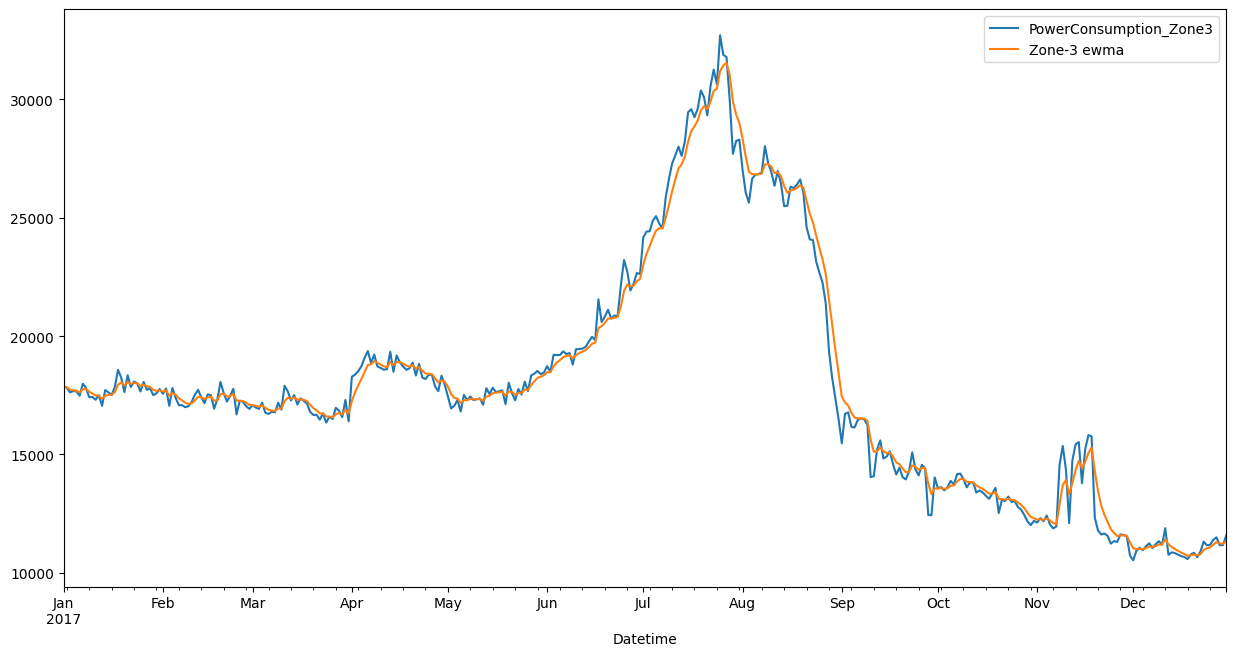

In [91]:
daily_resample[['PowerConsumption_Zone1','Zone-1 ewma']].plot(figsize=(15,7.5))
daily_resample[['PowerConsumption_Zone2','Zone-2 ewma']].plot(figsize=(15,7.5))
daily_resample[['PowerConsumption_Zone3','Zone-3 ewma']].plot(figsize=(15,7.5))

<Axes: xlabel='Datetime'>

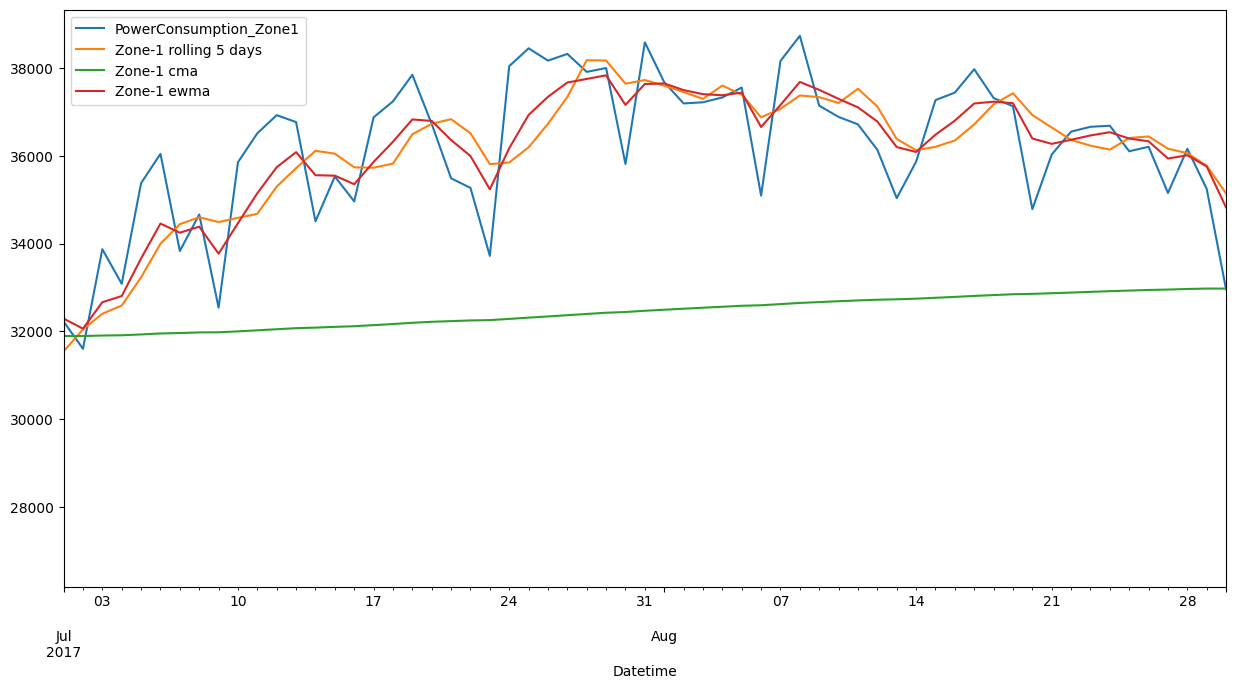

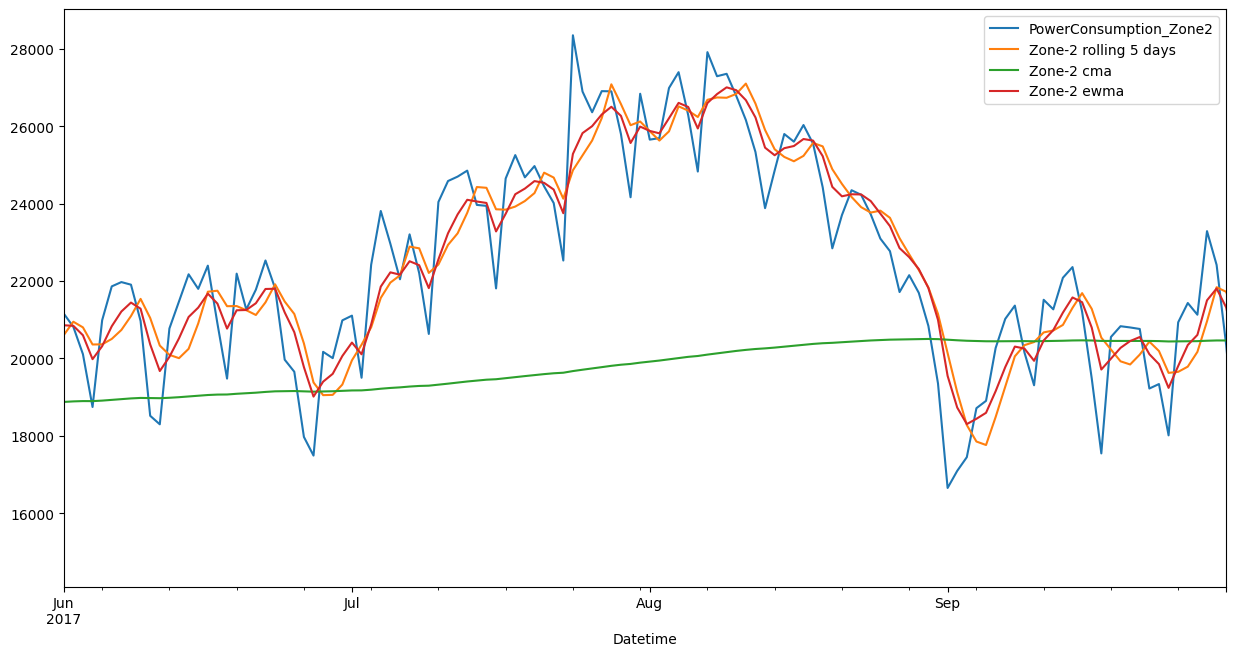

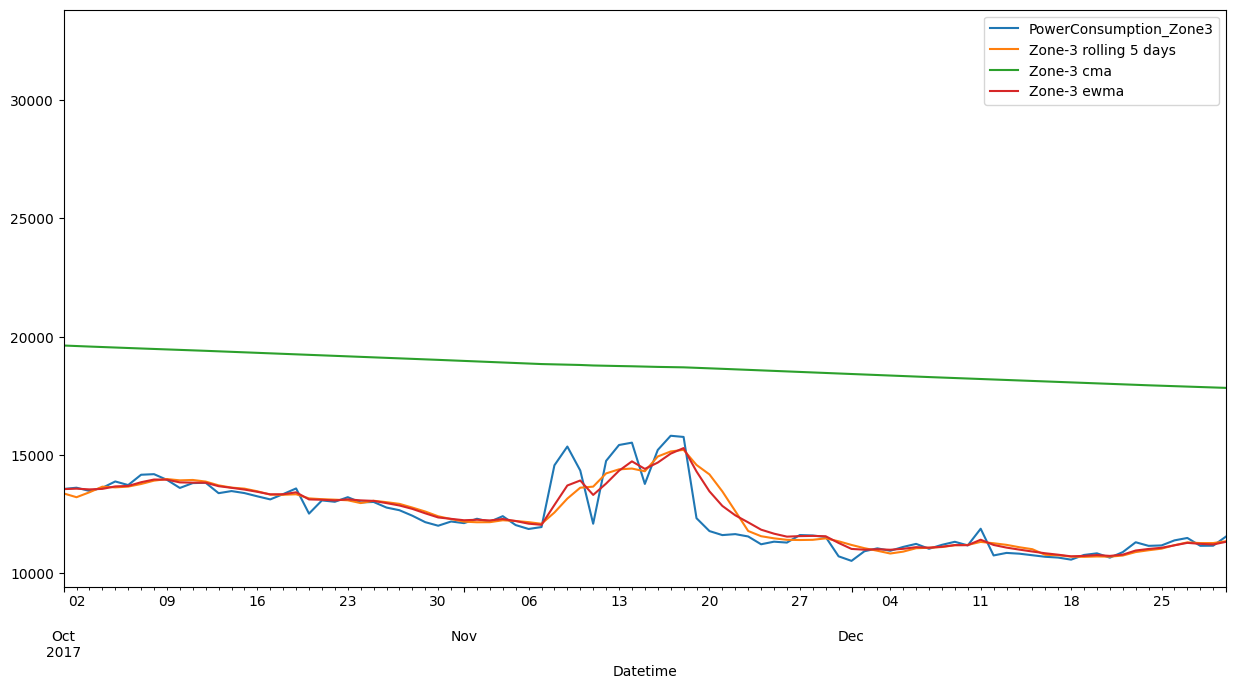

In [95]:
#Comparing which moving average is giving the best results
daily_resample[['PowerConsumption_Zone1','Zone-1 rolling 5 days','Zone-1 cma','Zone-1 ewma']].plot(figsize=(15,7.5),xlim=('2017-07-01','2017-08-30'))
daily_resample[['PowerConsumption_Zone2','Zone-2 rolling 5 days','Zone-2 cma','Zone-2 ewma']].plot(figsize=(15,7.5),xlim=('2017-06-01','2017-09-30'))
daily_resample[['PowerConsumption_Zone3','Zone-3 rolling 5 days','Zone-3 cma','Zone-3 ewma']].plot(figsize=(15,7.5),xlim=('2017-10-01','2017-12-30'))

In [96]:
#Rolling of indipendent features.
daily_resample['Temperature rolling 5 days']=daily_resample['Temperature'].rolling(window=5).mean()
daily_resample['Humidity rolling 5 days']=daily_resample['Humidity'].rolling(window=5).mean()
daily_resample['WindSpeed rolling 5 days']=daily_resample['WindSpeed'].rolling(window=5).mean()
daily_resample['DiffuseFlows rolling 5 days']=daily_resample['DiffuseFlows'].rolling(window=5).mean()

In [97]:
#cma of indipendent features
daily_resample['Temperature cma']=daily_resample['Temperature'].expanding().mean()
daily_resample['Humidity cma']=daily_resample['Humidity'].expanding().mean()
daily_resample['WindSpeed cma']=daily_resample['WindSpeed'].expanding().mean()
daily_resample['DiffuseFlows cma']=daily_resample['DiffuseFlows'].expanding().mean()

In [98]:
#ewma of indipendent features
daily_resample['Temperature ewma']=daily_resample['Temperature'].ewm(span=5).mean()
daily_resample['Humidity ewma']=daily_resample['Humidity'].ewm(span=5).mean()
daily_resample['WindSpeed ewma']=daily_resample['WindSpeed'].ewm(span=5).mean()
daily_resample['DiffuseFlows ewma']=daily_resample['DiffuseFlows'].ewm(span=5).mean()

<Axes: xlabel='Datetime'>

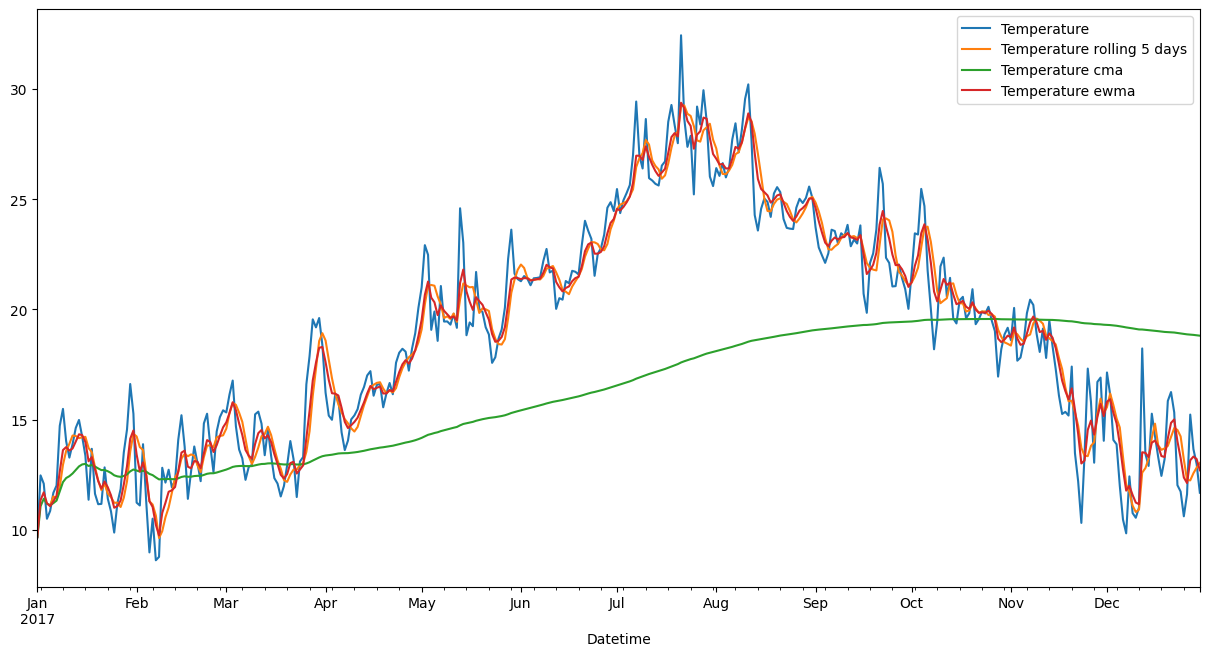

In [99]:
#comparing all the moving average techniques
daily_resample[['Temperature','Temperature rolling 5 days','Temperature cma','Temperature ewma']].plot(figsize=(15,7.5))

<Axes: xlabel='Datetime'>

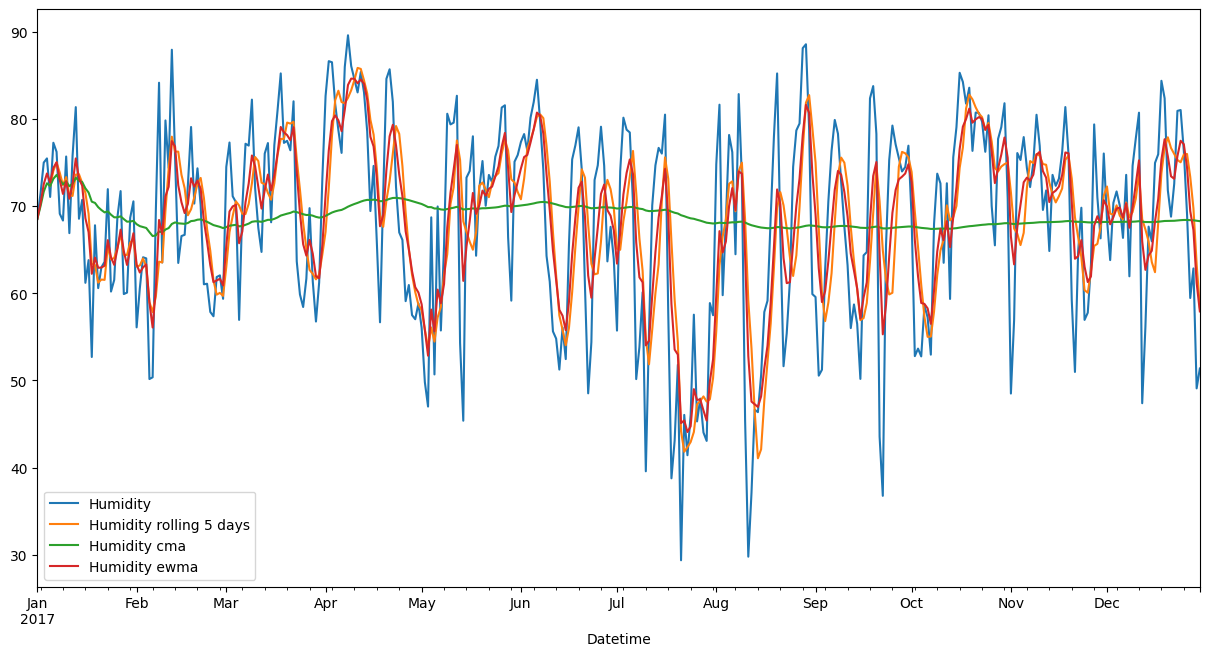

In [ ]:
daily_resample[['Humidity','Humidity rolling 5 days','Humidity cma','Humidity ewma']].plot(figsize=(15,7.5))

<Axes: xlabel='Datetime'>

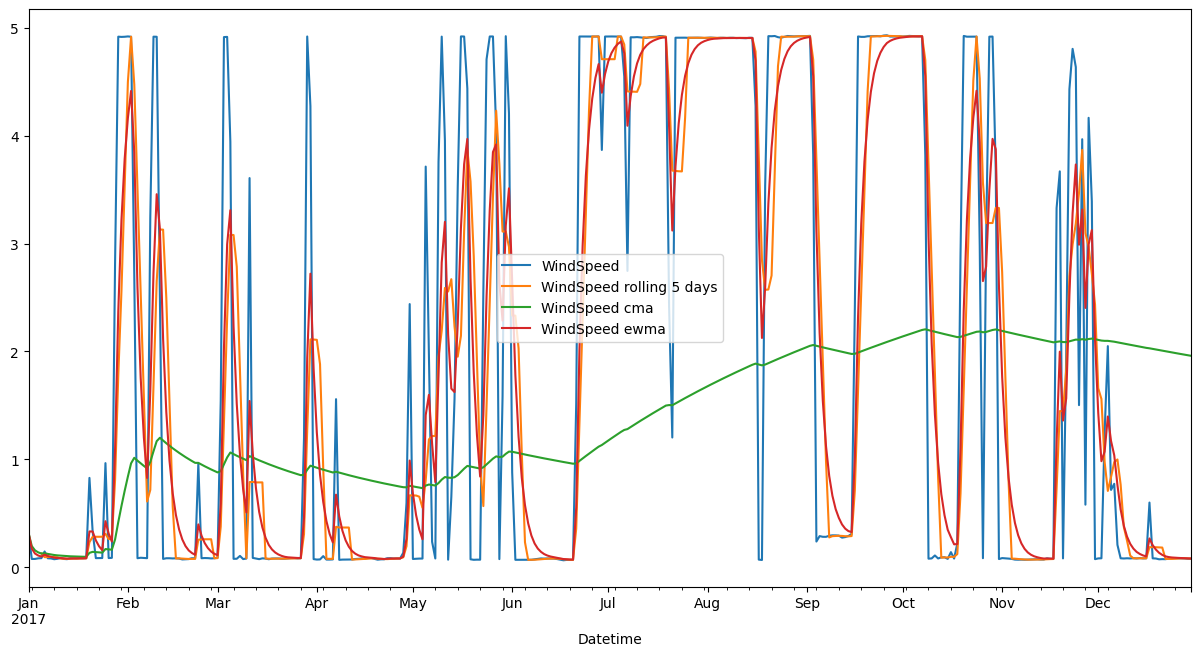

In [ ]:
daily_resample[['WindSpeed','WindSpeed rolling 5 days','WindSpeed cma','WindSpeed ewma']].plot(figsize=(15,7.5))

<Axes: xlabel='Datetime'>

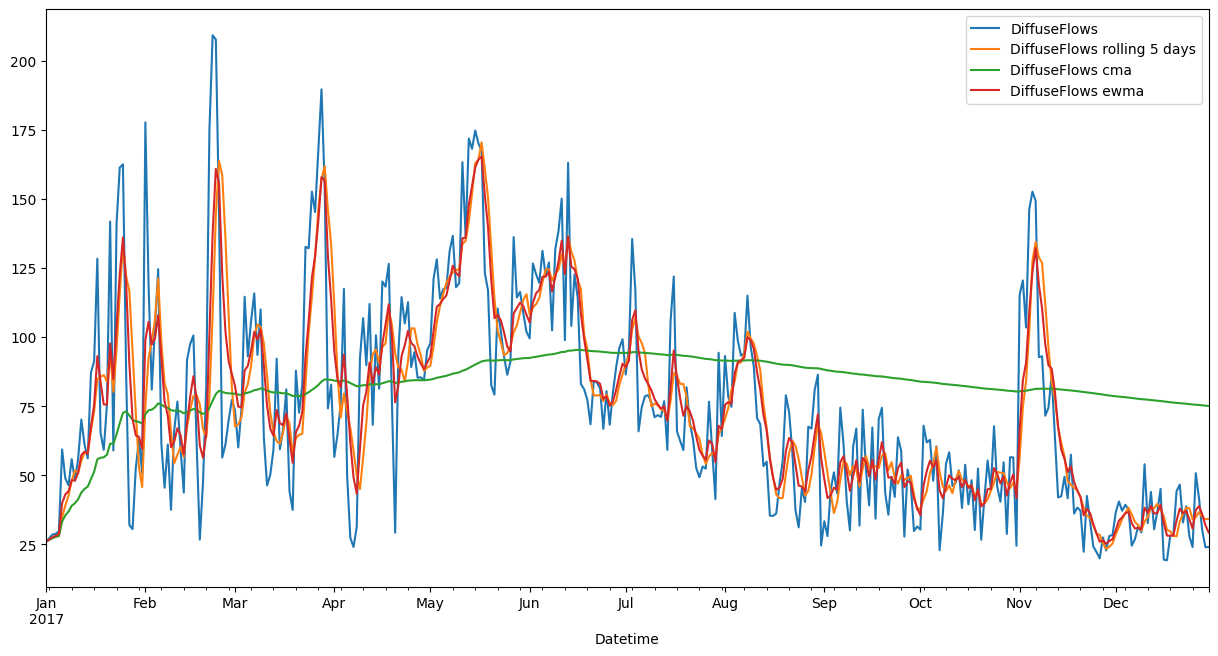

In [100]:
daily_resample[['DiffuseFlows','DiffuseFlows rolling 5 days','DiffuseFlows cma','DiffuseFlows ewma']].plot(figsize=(15,7.5))

##Checking the stationarity with Stastical Method

In [101]:
m=daily_resample['PowerConsumption_Zone1'].mean()
m


32344.97056358593

In [102]:
std=daily_resample['PowerConsumption_Zone1'].std()
std

2669.3679649176265

In [103]:
daily_resample.head()

Temperature   Humidity  WindSpeed  GeneralDiffuseFlows  \
Datetime                                                             
2017-01-01     9.675299  68.519306   0.315146           121.390771   
2017-01-02    12.476875  71.456319   0.076563           120.404486   
2017-01-03    12.100000  74.981667   0.076715           120.686014   
2017-01-04    10.509479  75.459792   0.082417           122.959319   
2017-01-05    10.866444  71.040486   0.083896           118.749861   

            DiffuseFlows  PowerConsumption_Zone1  PowerConsumption_Zone2  \
Datetime                                                                   
2017-01-01     25.993924            28465.232067            17737.791287   
2017-01-02     27.227410            28869.493671            19557.725431   
2017-01-03     28.574660            30562.447257            20057.269504   
2017-01-04     28.827222            30689.831224            20102.077001   
2017-01-05     29.741437            30802.911393            20033.941237   

            PowerConsumption_Zone3    year  month  ...  \
Datetime                                           ...   
2017-01-01            17868.795181  2017.0    1.0  ...   
2017-01-02            17820.763053  2017.0    1.0  ...   
2017-01-03            17620.803213  2017.0    1.0  ...   
2017-01-04            17673.694779  2017.0    1.0  ...   
2017-01-05            17664.176707  2017.0    1.0  ...   

            WindSpeed rolling 5 days  DiffuseFlows rolling 5 days  \
Datetime                                                            
2017-01-01                       NaN                          NaN   
2017-01-02                       NaN                          NaN   
2017-01-03                       NaN                          NaN   
2017-01-04                       NaN                          NaN   
2017-01-05                  0.126947                    28.072931   

            Temperature cma  Humidity cma  WindSpeed cma  DiffuseFlows cma  \
Datetime                                                                     
2017-01-01         9.675299     68.519306       0.315146         25.993924   
2017-01-02        11.076087     69.987812       0.195854         26.610667   
2017-01-03        11.417391     71.652431       0.156141         27.265331   
2017-01-04        11.190413     72.604271       0.137710         27.655804   
2017-01-05        11.125619     72.291514       0.126947         28.072931   

            Temperature ewma  Humidity ewma  WindSpeed ewma  DiffuseFlows ewma  
Datetime                                                                        
2017-01-01          9.675299      68.519306        0.315146          25.993924  
2017-01-02         11.356244      70.281514        0.171996          26.734015  
2017-01-03         11.708550      72.507902        0.126863          27.605899  
2017-01-04         11.210474      73.734072        0.108401          28.113218  
2017-01-05         11.078406      72.700041        0.098994          28.738269  

[5 rows x 51 columns]

##Next, we will **check the underlying statistics**. For this we will **split the time series into two sections** and check the mean and the variance. You could do more partitions if you wanted.


In [ ]:
no_of_partetions=2
partetion_len=int(len(daily_resample)/no_of_partetions)
partetion_len

182

In [ ]:
part_1_mean=daily_resample.head(partetion_len).mean()
part_2_mean=daily_resample.tail(partetion_len).mean()
part_1_var=daily_resample.head(partetion_len).var()
part_2_var=daily_resample.tail(partetion_len).var()
stationarity_test=pd.concat([part_1_mean,part_2_mean,part_1_var,part_2_var])
stationarity_test.columns=[['Partetion_1_mean','Partetion_2_mean','Partetion_1_var','Partetion_2_var']]

In [ ]:
stationarity_test

Temperature             16.556215
Humidity                69.708932
WindSpeed                1.174363
GeneralDiffuseFlows    188.472941
DiffuseFlows            94.236721
                          ...    
DiffuseFlows cma        33.677639
Temperature ewma        24.784504
Humidity ewma           77.827722
WindSpeed ewma           3.866405
DiffuseFlows ewma      480.062581
Length: 204, dtype: float64

In [ ]:
part_1_mean

Temperature                       16.556215
Humidity                          69.708932
WindSpeed                          1.174363
GeneralDiffuseFlows              188.472941
DiffuseFlows                      94.236721
PowerConsumption_Zone1         31896.586338
PowerConsumption_Zone2         19170.490581
PowerConsumption_Zone3         18143.005897
year                            2017.000000
month                              3.527473
week                              13.642857
day                               15.521978
hour                              11.500000
minute                            25.000000
dayofweek                          3.000000
quarter                            1.510989
season                             1.846154
dayofyear                         91.500000
dayofmonth                        15.521978
weekofyear                        13.642857
is_weekend                         0.285714
is_month_start                     0.038462
is_month_end                    

In [ ]:
part_2_mean

Temperature                       21.063833
Humidity                          66.810105
WindSpeed                          2.744615
GeneralDiffuseFlows              176.920287
DiffuseFlows                      55.819323
PowerConsumption_Zone1         32793.354789
PowerConsumption_Zone2         22914.527584
PowerConsumption_Zone3         17527.806540
year                            2017.000000
month                              9.494505
week                              39.357143
day                               15.835165
hour                              11.500000
minute                            25.000000
dayofweek                          3.000000
quarter                            3.500000
season                             3.170330
dayofyear                        273.500000
dayofmonth                        15.835165
weekofyear                        39.357143
is_weekend                         0.285714
is_month_start                     0.027473
is_month_end                    

Fitting the model

In [ ]:
x=df.drop(['PowerConsumption_Zone1','PowerConsumption_Zone2','PowerConsumption_Zone3'],axis=1)
y=df[['PowerConsumption_Zone1','PowerConsumption_Zone2','PowerConsumption_Zone3']]

In [ ]:
scaler=StandardScaler()
y_scaled=scaler.fit_transform(y)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y_scaled,random_state=42,shuffle=False,test_size=0.25)